<a href="https://colab.research.google.com/github/dbrody112/Mach_Learning_Remote_Sensing/blob/main/remote_sensing_proj2-Land_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ECE471 - Landcover Classification
* Instructor: Krishna Karra
* Email: krishna.karra@gmail.com
* Assigned: Monday March 15, 2021
* Due: Friday April 9, 2021

### For this assignment, you will be training a landcover classification model from the [National Landcover Database](https://www.usgs.gov/centers/eros/science/national-land-cover-database?qt-science_center_objects=0#).

The dataset consists of 1340 total samples. Every image is a 256x256 Landsat 8 image taken from spring to fall in 2016. You have been provided the following bands in each image file: 

* [coastal-aerosol, blue, green, red, nir, swir1, swir2, tirs1, cloud-mask, alpha]

An attempt was made to render each scene mostly cloud free, but a cloud mask is provided along with each image chip.

The corresponding target image to each image is a single-band image with NLCD classification labels taken from 2016.

Your over-arching goal is to build a pixel-wise segmentation model that outputs the following classes:

* [water, snow/ice, built area, bare, forest, shrub/scrub, grass, crops, wetlands]

Note that the number of classes your model needs to output is less than the number of classes in NLCD.

### Dataset details

The data exists in google cloud storage, in a public facing read-only storage bucket. You will access all the file links to access the data via a CSV file which also exists in the bucket, that contains the entire dataset that is available to be processed. See the example code for how to access these data. Rasterio will be able to load in a GeoTIFF file from a URL that corresponds to each file in cloud storage.

**Do not make an attempt to modify this storage bucket in any way, or I will get in trouble.**

### Task 1: Analyze the distribution of the dataset

Your first task is to analyze the distribution of the dataset. This will inform properties about your model (e.g. how well it will generalize). In particular, you should look at both the geographic spread of the where the dataset has been sampled, and the number of pixels that belong to each class. 

Note that since you will need to re-map the input NLCD labels to the specified output labels, you will want to look at the re-mapped distribution of pixels across the dataset.

Any other analysis that you do to better understand the underlying data (and which may affect your model parameters, architecture, etc.) falls under this section.

### Task 2: Train a landcover classification model

Your second task is to train a landcover classification model. I have given you some tensorflow code to get started, which should give you a sense of how to build a data loader and input pipeline. When implemented properly, tensorflow will manage the "lazy-loading" of the dataset for you (e.g. only loading as much data as it needs to at once to keep the GPU fed). 

A neural network architecture such as a UNet is a good choice, but you are free to use whatever model you choose. You are not required to use tensorflow (e.g. you can use Pytorch or just scikit-learn) but it may be the most straightforward choice given the code to get you started.

I expect you to think about ML concepts (and implement them if you decide they are applicable) such as:
* Train/val split
* Data normalization
* Data augmentation
* Regularization

Once your model is trained, I expect you to discuss the results (e.g. accuracy, validation loss) and show plots and analysis as appropriate.

### Evauation

Every model will be scored against a test set that I have that you do not have access to. In order to facilitate evaluation, you will be expected to provide a function that reads in your model, accepts takes an input file (in the same format as every training image) and outputs a single band classification raster that follows the classification scheme above.



## Code examples to get you started

In [ ]:
# we will use rasterio to read GeoTIFF files from cloud storage
!pip install rasterio
!pip install segmentation_models_pytorch
!pip install --upgrade plotly
!pip install plotly.express
!pip install albumentations==0.3.0
!pip install cartopy
!pip install folium==0.2.1
!pip install requests==2.23.0
!pip install osmnx
!pip install matplotlib==3.1.3

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)
  Using cached https://files.pythonhosted.org/packages/d4/d6/8a2906f51e073a4be80cab35cfa10e7a34853e60f3ed5304ac470852a08d/plotly_express-0.4.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1a/70/1935c770cb3be6e3a8b78ced23d7e0f3b187f5cbfab4749523ed65d7c9b1/requests-2.23.0-py2.py3-none-any.whl
ERROR: osmnx 1.0.1 has requirement matplotlib>=3.3, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: osmnx 1.0.1 has requirement requests>=2.25, but you'll have requests 2.23.0 which is incompatible.
  Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1


  Using cached https://files.pythonhosted.org/packages/29/c1/24814557f1d22c56d50280771a17307e6bf87b70727d975fd6b2ce6b014a/requests-2.25.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ce/63/74c0b6184b6b169b121bb72458818ee60a7d7c436d7b1907bd5874188c55/matplotlib-3.4.1-cp37-cp37m-manylinux1_x86_64.whl
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


  Using cached https://files.pythonhosted.org/packages/4c/9b/35ab3469fd1509f7636a344940569ebfd33239673fd2318e80b4700a257c/matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl
ERROR: osmnx 1.0.1 has requirement matplotlib>=3.3, but you'll have matplotlib 3.1.3 which is incompatible.
  Found existing installation: matplotlib 3.4.1
    Uninstalling matplotlib-3.4.1:
      Successfully uninstalled matplotlib-3.4.1


INSTALLING DEPENDENCIES

In [ ]:
# base imports

from glob import glob
import itertools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from osgeo import gdal
import pandas as pd
import rasterio
from random import shuffle
import sklearn.metrics as skmetrics
%tensorflow_version 2.x
import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import cv2
import segmentation_models_pytorch as smp
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.model_selection import KFold
from tqdm import tqdm
import cartopy.crs as ccrs
import osmnx as ox
from shapely.geometry import box
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
from PIL import Image

# check that a GPU is enabled
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Loading in file links

In [ ]:
# read in the CSV file that contains file links to the entire dataset
dataset_file = 'https://storage.googleapis.com/naip_public/dataset.csv'
df = pd.read_csv(dataset_file)
print(len(df))
df.head(5)

1340


images                                        targets
0  landsat:LC08:PRE:TOAR_6:125:30.0:12:-1096:2034...  nlcd:land_cover_6:125:30.0:12:-1096:20341.tif
1  landsat:LC08:PRE:TOAR_6:125:30.0:15:-998:20492...   nlcd:land_cover_6:125:30.0:15:-998:20492.tif
2  landsat:LC08:PRE:TOAR_6:125:30.0:17:-465:23054...   nlcd:land_cover_6:125:30.0:17:-465:23054.tif
3  landsat:LC08:PRE:TOAR_6:125:30.0:11:962:27264.tif    nlcd:land_cover_6:125:30.0:11:962:27264.tif
4  landsat:LC08:PRE:TOAR_6:125:30.0:16:756:27812.tif    nlcd:land_cover_6:125:30.0:16:756:27812.tif

In [ ]:
# use these as base directories for reading the dataset from cloud storage
image_base = 'https://storage.googleapis.com/naip_public/images'
target_base = 'https://storage.googleapis.com/naip_public/targets_v2'

In [ ]:
# load in file links from cloud storage
samples = list()
for idx, row in df.iterrows():
  image_file = os.path.join(image_base, row['images'])
  target_file = os.path.join(target_base, row['targets'])

  samples.append((image_file, target_file))

with rasterio.open(samples[0][0]) as src:
  img = src.read()

with rasterio.open(samples[0][1]) as src:
  tgt = src.read()

print(img.shape)
print(tgt.shape)
print(len(samples))

(10, 256, 256)
(1, 256, 256)
1340


### Visualization

In [ ]:
# NLCD color scheme
nlcd_color_mapping = {
    11: (70, 107, 159),
    12: (209, 222, 248),
    21: (222, 197, 255),
    22: (217, 146, 130),
    23: (235, 0, 0),
    24: (171, 0, 0),
    31: (179, 172, 159),
    41: (104, 171, 95),
    42: (28, 95, 44),
    43: (181, 197, 143),
    52: (204, 184, 121),
    71: (223, 223, 194),
    81: (220, 217, 57),
    82: (171, 108, 40),
    90: (184, 217, 235),
    95: (108, 159, 184),
}

# NLCD class mapping
nlcd_name_mapping = {
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands',
}

In [ ]:
# build a matplotlib colormap so we can visualize this data
colors = list()
for idx, class_val in enumerate(nlcd_color_mapping.keys()):
  red, green, blue = nlcd_color_mapping[class_val]

  color_vec = np.array([red/255, green/255, blue/255])
  colors.append(color_vec)

colors = np.stack(colors)
cmap = matplotlib.colors.ListedColormap(colors=colors, N=len(colors))

bounds = list(range(len(colors)))
norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))

In [ ]:
# write a function so that we can display image/target/predictions
def display_image_target(display_list, mode= 'rgb'):
  plt.figure(dpi=200)
  title = ['Image', 'Target', 'Prediction']
  for idx, disp in enumerate(display_list):
    plt.subplot(1, len(display_list), idx+1)
    plt.title(title[idx], fontsize=6)
    plt.axis('off')

    if title[idx] == 'Image':
      arr = disp.numpy()
      if(mode == 'rgb'):
        rgb = np.stack([arr[:, :, 3], arr[:, :, 2], arr[:, :, 1]], axis=-1) / 3000.0
        
        plt.imshow(rgb)
      elif(mode == 'test'):
        plt.imshow(arr)


    elif title[idx] == 'Target':
      tgt = disp.numpy().squeeze()
      plt.imshow(tgt, interpolation='none', norm=norm, cmap=cmap)

    elif title[idx] == 'Prediction':
      pred = np.argmax(disp, axis=-1) # argmax across probabilities to get class outputs
      plt.imshow(pred, interpolation='none', norm=norm, cmap=cmap)

  plt.show()
  plt.close()

In [ ]:
class SegmentationDataset16(Dataset):
  def __init__(self, data_path,image_transform=None, target_transform=None):

    '''
    returns dataset from file as needed e.g. by specifying index / idx

    INPUTS:

    data_path : <array of strings> list of links where the images and targets are stored.
    each entry in data_path should have the following form (image_path, target_path)

    image_transform : <Albumentations or torchvision Compose object> transforming the image data with augumentations
    with a certain probability e.g. horizontal flip with probability 0.5

    target_transform : <Albumentations or torchvision Compose object> transforming the target data with augumentations
    with a certain probability e.g. horizontal flip with probability 0.5
    
    *Note that the transforms are not implemented in this class but may be implemented later

    OUTPUTS:

    (image, mask) : <tuple> remote sensing image and mask that corresponds to that image. The mask is made up of
    values of 0 : num_classes - 1 so in this case values range from 0:15
    '''

    self.data_path = data_path
    self.image_transform = image_transform
    self.target_transform = target_transform
  
  def __len__(self):
        return len(self.data_path)

  def __getitem__(self, idx) ->tuple:
    
    path = self.data_path[idx]
    image_path, target_path = path[0], path[1]
    with rasterio.open(image_path) as src:
      img = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.int16)

    with rasterio.open(target_path) as src:
      tgt = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.uint8)

    tgt_out = np.zeros(tgt.shape, dtype=np.uint8)
    for class_val, nlcd_val in enumerate(nlcd_color_mapping.keys()):
      tgt_out[tgt == nlcd_val] = class_val

    # wrap custom dataloadeer into tensorflow
    image, target = torch.from_numpy(img), torch.from_numpy(tgt_out)
    image = image.view(256, 256, 10).type(torch.float32)
    target = target.view(256, 256, 1).type(torch.uint8)

    
    return image,target


In [ ]:
ds16 = SegmentationDataset16(samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


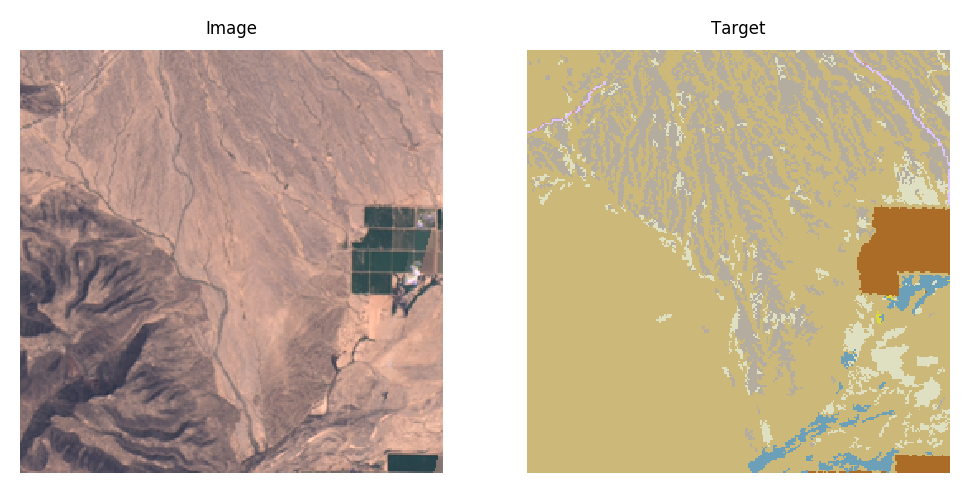

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


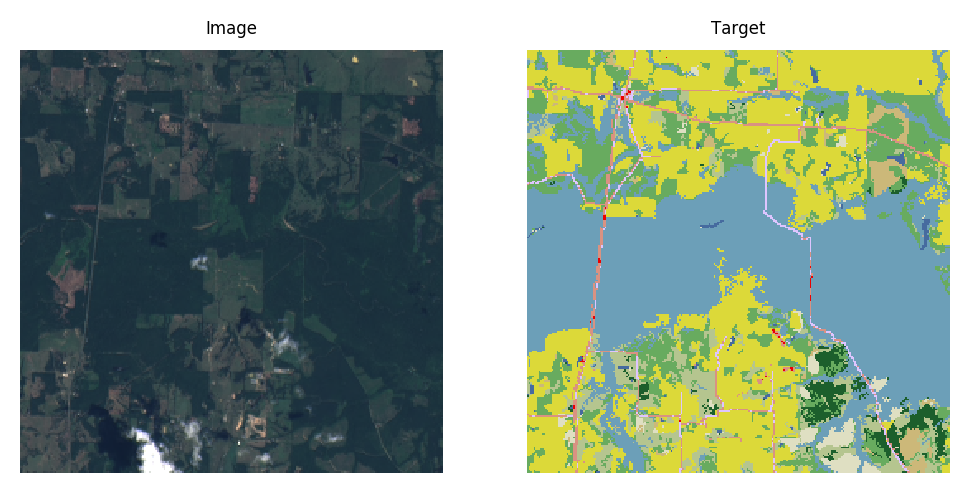

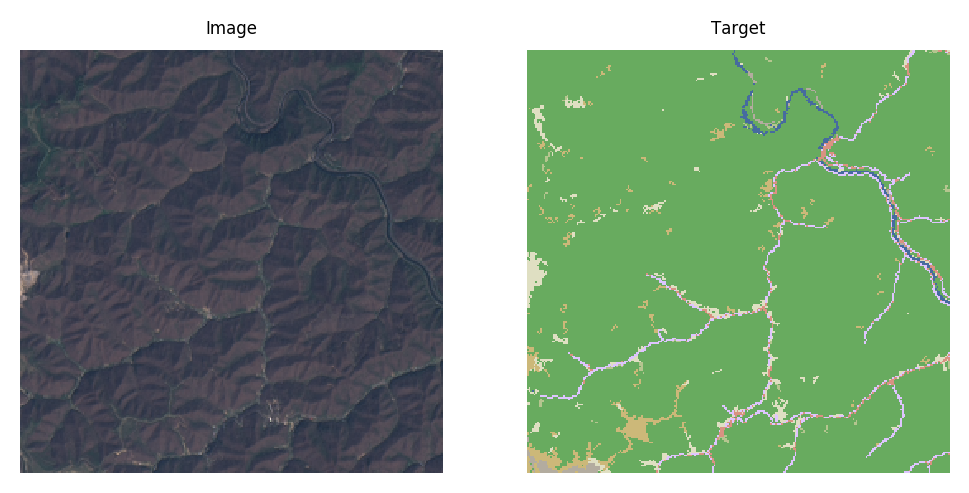

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


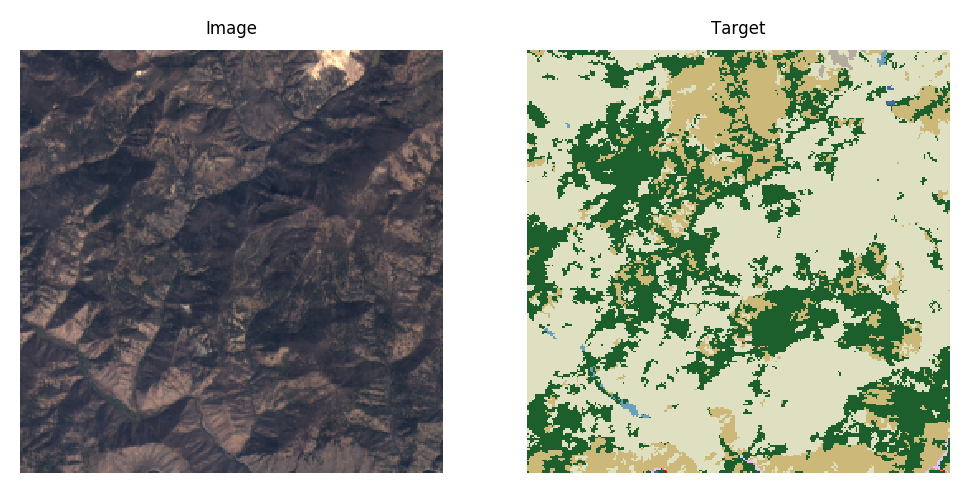

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


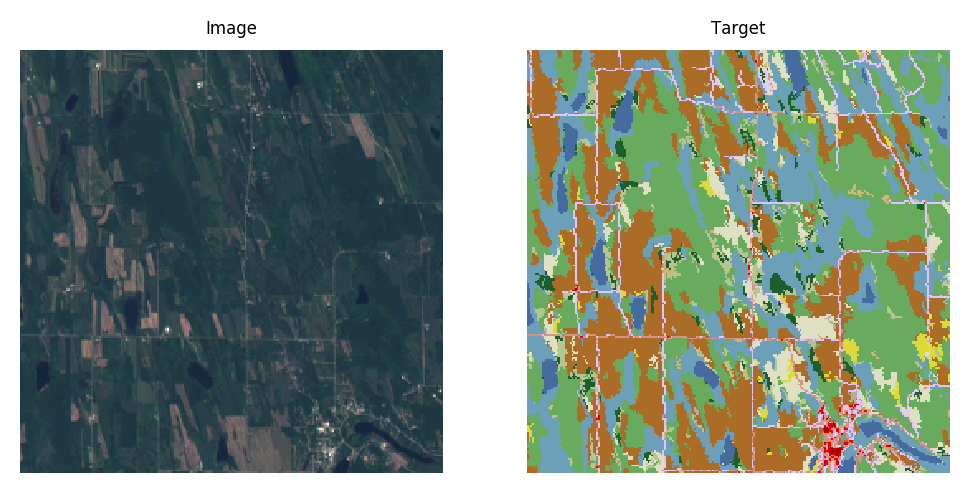

In [ ]:
for image,target in [ds16[i] for i in range(5)]:
  display_image_target([image,target])

16 Class Histogram

In [ ]:
value_count_dict = {i:0 for i in range(len(nlcd_color_mapping))}

In [ ]:
for i in range(len(ds16)):
  if(i%10 == 0):
    print(i)
  numbers,counts = np.unique(ds16[i][1].view(256*256,-1).numpy(), return_counts=True)
  for idx,num in enumerate(numbers):
    value_count_dict[num] = value_count_dict[num] + counts[idx]


Text(0.5, 0, 'class')

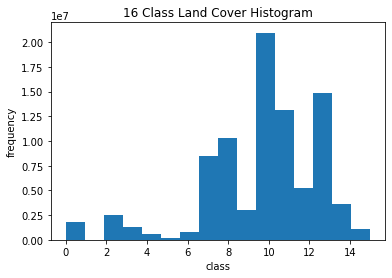

In [ ]:
arr = []
for i in value_count_dict:
  arr.append(np.ones((value_count_dict[i],1))*i)
arr = np.concatenate(arr)
plt.hist(arr, bins = len(nlcd_color_mapping))
plt.title('16 Class Land Cover Histogram')
plt.ylabel('frequency')
plt.xlabel('class')

*Diagram Explanation*

From this diagram it is obvious that the dataset is highly imbalanced with a very small distribution for class 0 and a large distribution for class 10

Remapping Dicts

In [ ]:
#dictionaries used to remap the classes from 16 to 10 using the specified parameters of the

class_dict_name_conversion={
    11: 'water',
    12 : 'snow',
    21: 'built_area',
    22: 'built_area',
    23: 'built_area',
    24: 'built_area',
    31: 'bare',
    41: 'forest',
    42: 'forest',
    43: 'forest',
    52: 'shrub_or_scrub',
    71: 'grass',
    81: 'crops',
    82: 'crops',
    90: 'wetlands',
    95: 'wetlands', 
}

class_dict_pixel_remapping = {
    11: 0,
    12: 1,
    21: 2,
    22: 2,
    23: 2,
    24: 2,
    31: 3,
    41: 4,
    42: 4,
    43: 4,
    52: 5,
    71: 6,
    81: 7,
    82: 7,
    90: 8,
    95: 8,
}

9 Class Remapped Dataset

In [ ]:



class SegmentationDataset9(Dataset):
  def __init__(self, data_path,image_transform=None, target_transform=None):
    '''
    returns dataset from file as needed e.g. by specifying index / idx

    INPUTS:

    data_path : <array of strings> list of links where the images and targets are stored.
    each entry in data_path should have the following form (image_path, target_path)

    image_transform : <Albumentations or torchvision Compose object> transforming the image data with augumentations
    with a certain probability e.g. horizontal flip with probability 0.5

    target_transform : <Albumentations or torchvision Compose object> transforming the target data with augumentations
    with a certain probability e.g. horizontal flip with probability 0.5
    
    *Note that the transforms are not implemented in this class but may be implemented later

    OUTPUTS:

    (image, mask) : <tuple> remote sensing image and mask that corresponds to that image. The mask is made up of
    values of 0 : num_classes - 1 so in this case values range from 0:8
    '''

    self.data_path = data_path
    self.image_transform = image_transform
    self.target_transform = target_transform
  
  def __len__(self):
        return len(self.data_path)

  def __getitem__(self, idx) ->tuple:
    
    path = self.data_path[idx]
    image_path, target_path = path[0], path[1]
    with rasterio.open(image_path) as src:
      img = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.int16)

    with rasterio.open(target_path) as src:
      tgt = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.uint8)

    tgt_out = np.zeros(tgt.shape, dtype=np.uint8)
    for nlcd_val in class_dict_pixel_remapping.keys():
      tgt_out[tgt == nlcd_val] = class_dict_pixel_remapping[nlcd_val]

    
    image, target = torch.from_numpy(img), torch.from_numpy(tgt_out)
    image = image.view(256, 256, 10).type(torch.float32)
    target = target.view(256, 256, 1).type(torch.uint8)

    
    return image,target

In [ ]:
ds10 = SegmentationDataset9(samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


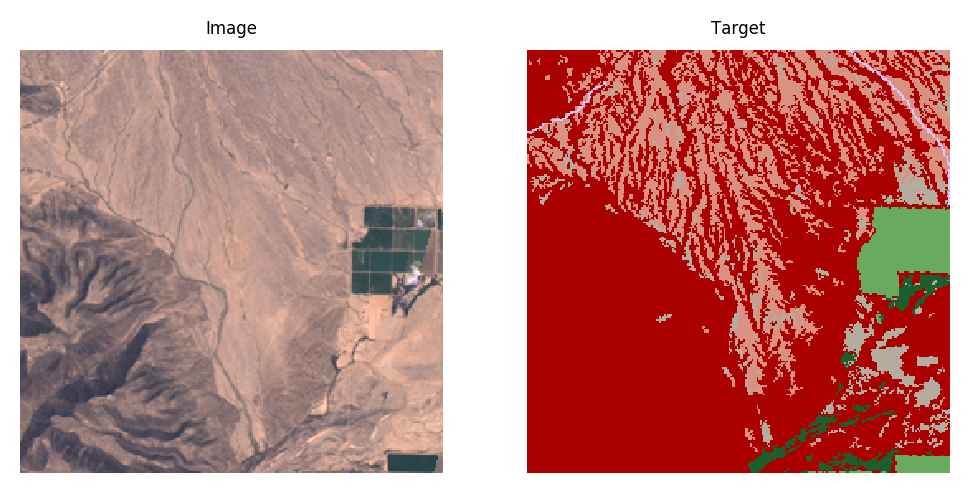

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


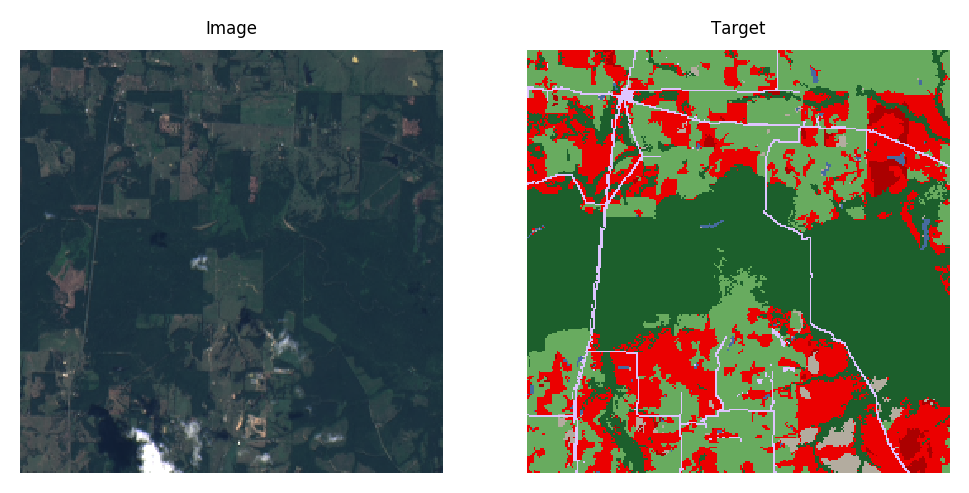

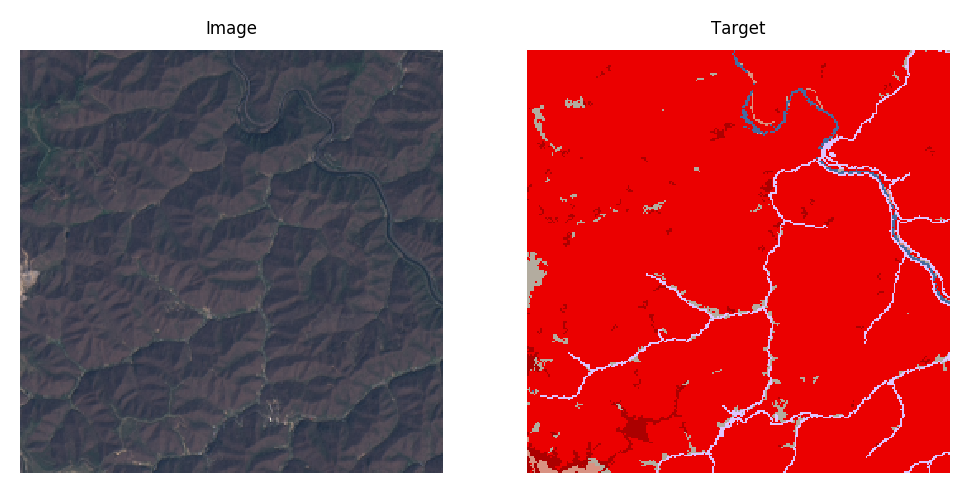

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


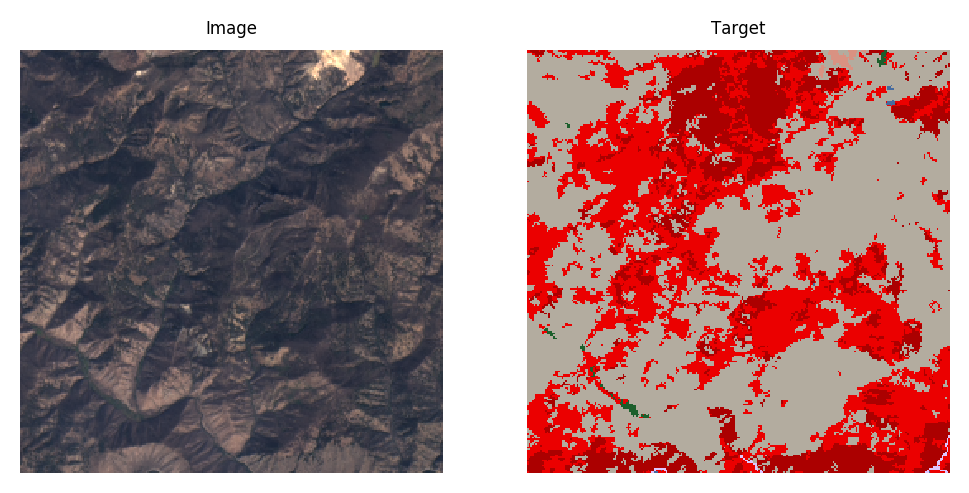

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


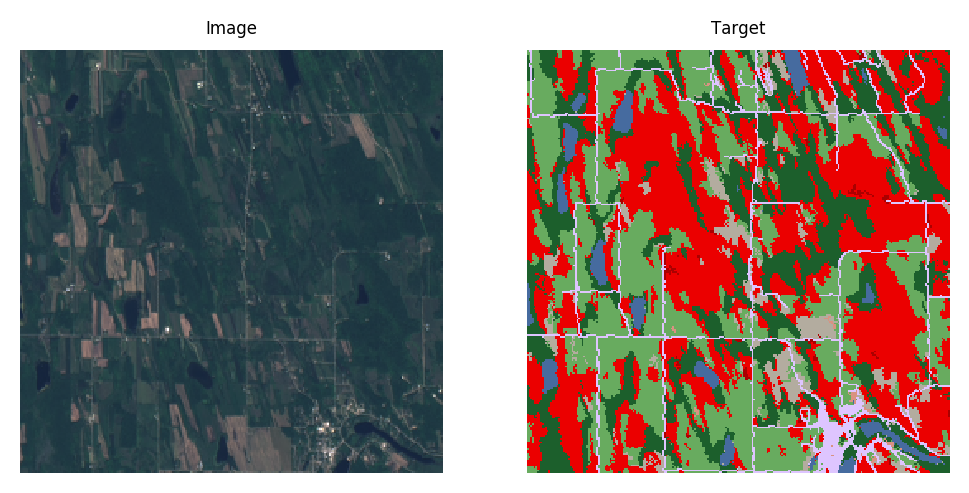

In [ ]:
for image,target in [ds10[i] for i in range(5)]:
  display_image_target([image,target])

**Geographic Spread Exploration**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:



#*Note: need a folder known as correct_crs in drive for this to work and also need to mount drive
#convert_crs taken from the following rasterio docs : https://rasterio.readthedocs.io/en/latest/topics/reproject.html

def convert_crs(dst_crs,dst_file_name,data_path,idx):
  '''
  converts coordinate system of all images to the same coordinate system.
  In this case the function was used to convert to EPSG for OpenStreetMap and to make sure all of the extents in the dataset are of the same unit.
  e.g. if images have different crs they may have the same extent in the same crs but different in another.

  INPUTS:

  dst_crs : <string> coordinate system to convert the image to

  dst_file_name : <string> location to place the new image with updated crs

  data_path : <array of strings> list of links where the images and targets are stored.
    each entry in data_path should have the following form (image_path, target_path)
  
  idx : index of data in data_path where the image you want to update is
  
  '''
  path = data_path[idx]
  image_path, target_path = path[0], path[1]
  with rasterio.open(image_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(dst_file_name, 'w', **kwargs) as dst:
      for i in range(1, src.count + 1):
        reproject(
             source=rasterio.band(src, i),
             destination=rasterio.band(dst, i),
             src_transform=src.transform,
             src_crs=src.crs,
             dst_transform=transform,
             dst_crs=dst_crs,
             resampling=Resampling.nearest)
        
for i in range(len(ds10)):
  print(i)
  convert_crs(dst_crs ='EPSG:4326', dst_file_name = "/content/gdrive/MyDrive/correct_crs/img"+str(i)+".tif", data_path = samples,idx = i)

In [ ]:
#finding bounding box of area of dataset

import glob
initial_bounds = np.zeros((4,1))
for name in glob.glob('/content/gdrive/MyDrive/correct_crs'+'/*.tif'):
  ds = rasterio.open(name)
  print(ds.bounds)
  for i in range(len(initial_bounds)):
    if((i+1)%2==0):
      if(ds.bounds[i] > initial_bounds[i]):
        initial_bounds[i] = ds.bounds[i]
    else:
      if(ds.bounds[i] < initial_bounds[i]):
        initial_bounds[i] = ds.bounds[i]
  
  

**GeoDataframe of Whole Area**

Text(0.5, 1.0, 'bounding box for area based on open street map')

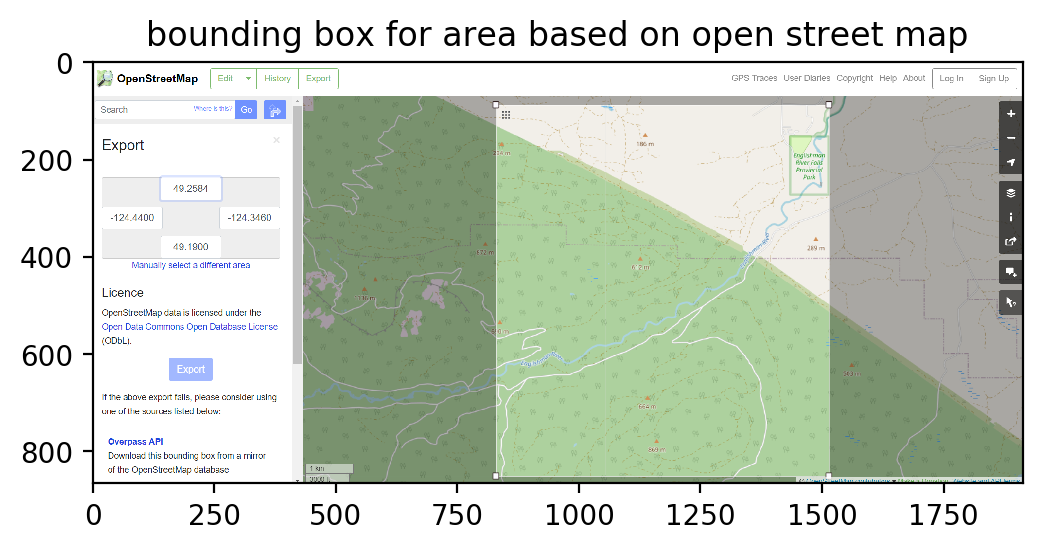

In [ ]:
#found in s3 bucket link here : https://remote-sensing-landcover.s3.us-east-2.amazonaws.com/openstreetmap.png


im = Image.open("/content/gdrive/MyDrive/openstreetmap.png")  
plt.figure(dpi=200)
plt.imshow(im)
plt.title("bounding box for area based on open street map")

Text(0.5, 1.0, 'overall region where the bounding box was classified in map')

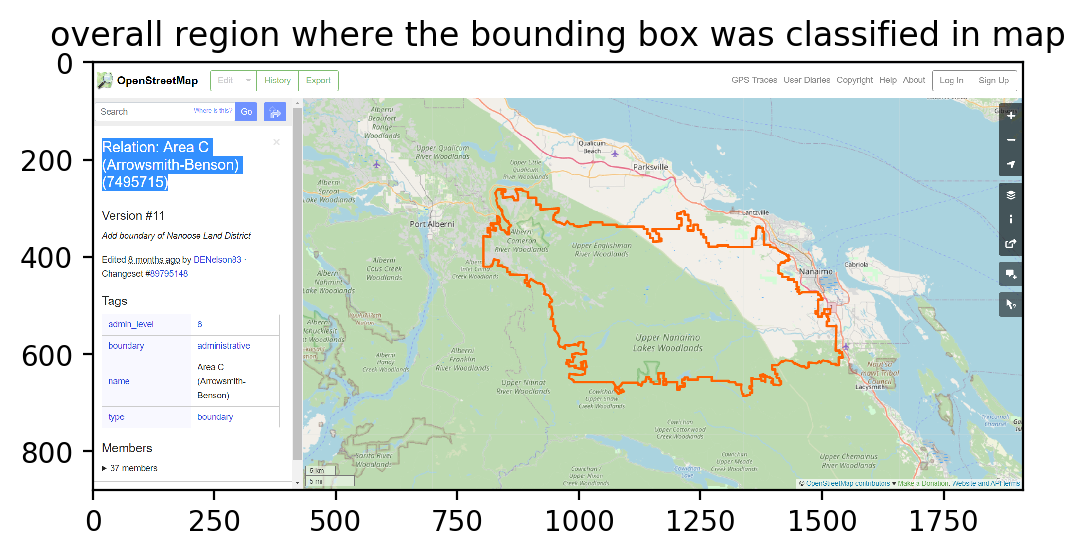

In [ ]:
#found in s3 bucket link here : https://remote-sensing-landcover.s3.us-east-2.amazonaws.com/area.png


im = Image.open("/content/gdrive/MyDrive/area.png")  
plt.figure(dpi=200)
plt.imshow(im)

plt.title("overall region where the bounding box was classified in map")

In [ ]:


geom = box(initial_bounds[0],initial_bounds[1],initial_bounds[2],initial_bounds[3])

#location found thru openstreet map: found in canada

df = gpd.GeoDataFrame({"id":1,"geometry":[geom],"location":"Relation: Area C (Arrowsmith-Benson) (7495715)"})

fig = px.choropleth(df,
                   geojson=df.geometry,
                   locations=df.index,
                   projection="mercator",
                   hover_name="location"
                   )
fig.update_geos(fitbounds="locations", visible=True)
fig.show()

**9 class histogram**

In [ ]:
value_count_dict = {i:0 for i in range(10)}

for i in range(len(ds10)):
  if(i%10 == 0):
    print(i)
  numbers,counts = np.unique(ds10[i][1].view(256*256,-1).numpy(), return_counts=True)
  for idx,num in enumerate(numbers):
    value_count_dict[num] = value_count_dict[num] + counts[idx]

Text(0.5, 0, 'class')

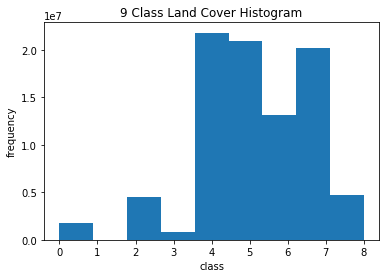

In [ ]:
arr = []
for i in value_count_dict:
  arr.append(np.ones((value_count_dict[i],1))*i)
arr = np.concatenate(arr)
plt.hist(arr, bins = 9)
plt.title('9 Class Land Cover Histogram')
plt.ylabel('frequency')
plt.xlabel('class')

*Diagram Conclusion*

From this diagram it is obvious that the dataset is highly imbalanced with a very small distribution for class 0 and a large distribution for class 4

**Random Forest Method to Find Best Bands**

In [ ]:
targeted_indices = []
indices=range(len(ds10))
kf = KFold(n_splits=13, shuffle = True)
for _, test in kf.split(indices):
  targeted_indices = test
  break

In [ ]:
importances = []
for idx, i in enumerate(targeted_indices):
  img, mask = ds10[i]
  if(idx % 5 == 0):
    print(" ")
    print(f'progress : {idx/(len(targeted_indices))}%')
    print(" ")
  arr = []
  for j in range(10):
    arr.append(img[:,:,j].view(256,256,1)[mask>0])
  X = np.transpose(np.stack(arr),(1,0))
  y = mask[mask>0].numpy()

  rf = RandomForestClassifier(n_estimators=100, oob_score=True, verbose=1, n_jobs=4)

  X = np.nan_to_num(X)
  rf2 = rf.fit(X, y)  
  importances.append([rf2.feature_importances_,rf.oob_score])

In [ ]:
importances = np.array(importances)
means = []
mean_oob_score = np.mean(importances[:,1])
for i in range(10):
  means.append([np.mean(np.stack(importances[:,0])[:,i])])

df = pd.DataFrame({'importances':means})
fig = px.bar(x =df.index,y =np.concatenate(df['importances']), title = 'band importances').update_yaxes(categoryorder = 'total descending')
fig.show()

*Diagram Conclusion*

Ultimately these band importances could be more accurate if, instead of splitting by K-Fold cross validation I used edge cases or some kind of distribution of class percentile in each image to decide the images to use the random forest classifier on. If given more time, I would implement the random forest as such. Ultimately, I used all of the bands except for the cloud mask and alpha band but this diagram was helpful in deciding the three most important bands to the dataset for functions that require images to be no more than 3-dimensional (e.g. smp.encoders.preprocessing_fn)

Model

In [ ]:
#following tutorial on following link: https://www.youtube.com/watch?v=IHq1t7NxS8k&t=788s for segmentation using UNet

#UNet taken from the following link: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/model.py

#following model from paper in 2015 with the addition of batch normalization

#batch normalization normalizes previous output by subtracting batch mean and dividing by batch standard deviation
#the batch normalization improves the model because it adds noise and therefore decreases the chance of overfitting, trains the model faster, allows for easier parameter
#initialization, overall improves model performance, and increases viability of activation functions


#in UNET diagram blue arrows are convolution and red arrows indicate pooling

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],dropout = False, dropout_rate = 0.5
    ):

        '''
        INPUTS:

        in_channels = input channels to first conv (based on dimensions / colors of images)

        out_channels = output channels from last conv (should be the number of classes in dataset)

        features = array of channel_nums to pass to encoder and decoder for convolution (outside of input and output convolution)

        OUTPUTS:

        x : prediction of mask for corresponding input image
        '''

        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = dropout
        self.dropout_rate = dropout_rate

        
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            if(self.dropout):
              x = nn.Dropout(p=self.dropout_rate)(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

**training utils**

In [ ]:
#save_checkpoint and load_checkpoint taken from the following github page : https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/utils.py

def save_checkpoint(state,filename):
  print("=> saving checkpoint")
  torch.save(state,filename)

def load_checkpoint(checkpoint,filename):
  print("=> loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(batch_size, num_workers = 0, train_transform = None, preprocessing = None,normalize = None):


  train_len = int(len(ds10)*(4/5))
  test_len = len(ds10) - train_len
  train_ds = []

  print("loading training set ...")
  print(" ")

  for i in range(train_len):
    image,target = ds10[i]
    image = image.numpy()
    image_stack = np.stack([image[:,:,7],image[:,:,6],image[:,:,5],image[:,:,4],image[:,:,3],image[:,:,2],image[:,:,1],image[:,:,0]], axis=-1)
    if(normalize):
      image_stack = np.stack([normalize(image[:,:,7]),normalize(image[:,:,6]),normalize(image[:,:,5]),normalize(image[:,:,4]),normalize(image[:,:,3]),normalize(image[:,:,2]),normalize(image[:,:,1]),normalize(image[:,:,0])], axis=-1)
   
    img = train_transform(image = image_stack, mask = target.numpy())
    image_trn = torch.transpose(torch.from_numpy(img['image']),0,2)
    mask_trn = torch.from_numpy(img['mask'])
    img_numpy = torch.transpose(image_trn,0,2).numpy()
    
    
    train_ds.append(tuple((image_trn,mask_trn)))
  
    if(i%50==0):
      print(f'progress: {np.round_(i/train_len,decimals = 2)*100}%')
    if(normalize):
      if(i%200==0):
        display_image_target([torch.transpose(image_trn,0,2)*3000,mask_trn])
    else:
      if(i%200==0):
        display_image_target([torch.transpose(image_trn,0,2),mask_trn])


      
  
  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      shuffle = True
  )

  print("loading testing set ... ")
  print(" ")

  test_ds = []
  for i in range(train_len,len(ds10)):
    image,target = ds10[i]
    image = image.numpy()
    image = np.stack([image[:,:,7],image[:,:,6],image[:,:,5],image[:,:,4],image[:,:,3],image[:,:,2],image[:,:,1],image[:,:,0]], axis=-1)
    if(normalize):
      image = np.stack([normalize(image[:,:,7]),normalize(image[:,:,6]),normalize(image[:,:,5]),normalize(image[:,:,4]),normalize(image[:,:,3]),normalize(image[:,:,2]),normalize(image[:,:,1]),normalize(image[:,:,0])], axis=-1)
    image_tensor = torch.transpose(torch.from_numpy(image),0,2)
    
    test_ds.append(tuple((image_tensor,target)))

    if(i%50==0):
      print(f'progress: {np.round_((i-train_len)/test_len,decimals = 2)*100}%')



  val_loader = DataLoader(
      test_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      shuffle = True
  )

  return train_loader, val_loader

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))






**loss utils**

In [ ]:
class CategoricalCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CategoricalCrossEntropyLoss, self).__init__()

    def forward(self, y_hat, y):
        y = torch.transpose(F.one_hot(y),1,3)
        return nn.NLLLoss()(torch.log_softmax(y_hat,dim=1), torch.argmax(y, dim=1))


**accuracy utils**

In [ ]:
#https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/

class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

#check_accuracy and save_predictions_as_imgs similar as same functions in the following link : https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/utils.py 

def check_accuracy(loader, model, device="cuda",mode="val"):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        for image, target in loader:
            image = image.to(device)
            target =target.view(-1,256,256).type(torch.uint8).to(device)
            preds = torch.nn.LogSoftmax(dim=1)(model(image))
            
            preds = torch.argmax(preds,dim=1).type(torch.uint8).view(-1,256,256)
            
            num_correct += (preds == target).sum()
            num_pixels += torch.numel(preds)
            
    if(mode == "val"):
      print(
          f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f} for validation"
          )
    else:
      print(
          f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f} for training"
          )

    model.train()

    return num_correct/num_pixels

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (image, target) in enumerate(loader):
        image = image.to(device=device)
        with torch.no_grad():
            preds = torch.log_softmax(model(image),dim=1)
            preds = torch.argmax(preds,dim=1).type(torch.long).view(-1,256,256)
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(target.type(torch.long).view(-1,256,256), f"{folder}{idx}.png")

    model.train()

**training**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

normalize = lambda x : MinMaxScaler().fit_transform(x)

train_transform = A.Compose([
       #A.HorizontalFlip(), 
       #A.VerticalFlip(),  
       #A.RandomBrightnessContrast(), 
       #A.RandomGamma(), 
       #A.Cutout(),
       #A.ShiftScaleRotate(),
       #A.GridDistortion(),
       #A.GaussNoise(),
       
])

#unfortunately I was not able to test the normalization but I am sure that it would improve accuracy

train_loader, val_loader = get_loaders(batch_size = 10, train_transform =train_transform)
                                       
#normalize = normalize

In [ ]:
#traininh sequence similar to the following link : https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/train.py

def train(loader, model, optimizer, loss_fn,scaler,scheduler):
  loop = tqdm(loader)
  lr = 0
  for batch, (image, target) in enumerate(loop):
   
    image = image.type(torch.float32).to(device)
    target =target.type(torch.long).view(-1,256,256).to(device)
    
    with torch.cuda.amp.autocast():
        predictions = model(image)
        
        loss = loss_fn(predictions, target)

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    if(scheduler):
      scheduler.step()
      lr = scheduler.get_last_lr()
    
    loop.set_postfix(loss=loss.item())
  return lr


#commented out model is native to segmentation-models-pytorch module. This was preliminary.
#The specifications were using resnet34 as the encoder, using pre-trained imagenet weights (to take advantage of transfer learning),
#and appropriate input and output channels


#model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None, in_channels = 8, classes = 10).to(device) #for dropout add aux_params

#This model is what I refer to as  "model_scratch" in my s3 bucket. This is the implemented model that I defined above.
#I found it best when dropout_rate = 0 but it's likely that under more changes dropout would give an improvement consideringf its regularizing effect

model = UNET(in_channels = 8, out_channels = 10,dropout = True, dropout_rate = 0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
scaler = torch.cuda.amp.GradScaler()

#shown below are three variants of cross entropy loss.
#The first is the Pytorch version, the second is the weighted version (to deal with imbalance), and the last is the tensorflow version.
#*Note that the weights of the weighted version are all frequencies of each respective class divided by the class with the largest number of frequencies. e.g. MinMaxScaler

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.CrossEntropyLoss(weight = torch.FloatTensor(np.array(list(value_count_dict.values()))/max(value_count_dict.values())).to(device))
#loss_fn = CategoricalCrossEntropyLoss()
NUM_EPOCHS = 60
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,len(train_loader))
test_accuracy = []
train_accuracy = []
lr = []

running model

In [ ]:
#sequence similar to cycle in the following link: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/train.py

for epoch in range(NUM_EPOCHS):
  
  print(f'epoch: {epoch}')
  lr.append(train(train_loader,model,optimizer, loss_fn, scaler = scaler,scheduler = scheduler))
  
  checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
  save_checkpoint(checkpoint,"my_checkpoint.pth.tar")
  
  test_accuracy.append(check_accuracy(val_loader, model, device=device, mode = 'val'))
  train_accuracy.append(check_accuracy(train_loader, model, device=device, mode = 'train'))
  
    
        
  #save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=device)





  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=2.38]



  1%|          | 1/108 [00:00<00:13,  7.71it/s, loss=2.38]

epoch: 0






  1%|          | 1/108 [00:00<00:13,  7.71it/s, loss=2.39]



  2%|▏         | 2/108 [00:00<00:13,  7.73it/s, loss=2.39]



  2%|▏         | 2/108 [00:00<00:13,  7.73it/s, loss=2.28]



  3%|▎         | 3/108 [00:00<00:13,  7.73it/s, loss=2.28]



  3%|▎         | 3/108 [00:00<00:13,  7.73it/s, loss=2.23]



  4%|▎         | 4/108 [00:00<00:13,  7.73it/s, loss=2.23]



  4%|▎         | 4/108 [00:00<00:13,  7.73it/s, loss=2.25]



  5%|▍         | 5/108 [00:00<00:13,  7.75it/s, loss=2.25]



  5%|▍         | 5/108 [00:00<00:13,  7.75it/s, loss=2.23]



  6%|▌         | 6/108 [00:00<00:12,  7.86it/s, loss=2.23]



  6%|▌         | 6/108 [00:00<00:12,  7.86it/s, loss=2.18]



  6%|▋         | 7/108 [00:00<00:12,  7.88it/s, loss=2.18]



  6%|▋         | 7/108 [00:01<00:12,  7.88it/s, loss=2.18]



  7%|▋         | 8/108 [00:01<00:12,  7.93it/s, loss=2.18]



  7%|▋         | 8/108 [00:01<00:12,  7.93it/s, loss=2.15]



  8%|▊         | 9/108 [00:01<00:12,  7.85it/s, loss=2.15]



  8%

=> saving checkpoint
Got 5949514/17563648 with acc 33.87 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.75]



  1%|          | 1/108 [00:00<00:13,  8.14it/s, loss=1.75]

Got 34078456/70254592 with acc 48.51 for training
epoch: 1






  1%|          | 1/108 [00:00<00:13,  8.14it/s, loss=1.8] 



  2%|▏         | 2/108 [00:00<00:13,  8.12it/s, loss=1.8]



  2%|▏         | 2/108 [00:00<00:13,  8.12it/s, loss=1.91]



  3%|▎         | 3/108 [00:00<00:13,  8.07it/s, loss=1.91]



  3%|▎         | 3/108 [00:00<00:13,  8.07it/s, loss=1.7] 



  4%|▎         | 4/108 [00:00<00:12,  8.06it/s, loss=1.7]



  4%|▎         | 4/108 [00:00<00:12,  8.06it/s, loss=1.86]



  5%|▍         | 5/108 [00:00<00:12,  7.97it/s, loss=1.86]



  5%|▍         | 5/108 [00:00<00:12,  7.97it/s, loss=1.85]



  6%|▌         | 6/108 [00:00<00:13,  7.85it/s, loss=1.85]



  6%|▌         | 6/108 [00:00<00:13,  7.85it/s, loss=1.74]



  6%|▋         | 7/108 [00:00<00:12,  7.91it/s, loss=1.74]



  6%|▋         | 7/108 [00:01<00:12,  7.91it/s, loss=1.8] 



  7%|▋         | 8/108 [00:01<00:12,  7.88it/s, loss=1.8]



  7%|▋         | 8/108 [00:01<00:12,  7.88it/s, loss=1.62]



  8%|▊         | 9/108 [00:01<00:12,  7.77it/s, loss=1.62]



  8%|▊ 

=> saving checkpoint
Got 5731746/17563648 with acc 32.63 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.7]



  1%|          | 1/108 [00:00<00:13,  8.15it/s, loss=1.7]

Got 33956040/70254592 with acc 48.33 for training
epoch: 2






  1%|          | 1/108 [00:00<00:13,  8.15it/s, loss=1.71]



  2%|▏         | 2/108 [00:00<00:13,  8.04it/s, loss=1.71]



  2%|▏         | 2/108 [00:00<00:13,  8.04it/s, loss=1.79]



  3%|▎         | 3/108 [00:00<00:13,  7.82it/s, loss=1.79]



  3%|▎         | 3/108 [00:00<00:13,  7.82it/s, loss=1.71]



  4%|▎         | 4/108 [00:00<00:13,  7.78it/s, loss=1.71]



  4%|▎         | 4/108 [00:00<00:13,  7.78it/s, loss=1.74]



  5%|▍         | 5/108 [00:00<00:13,  7.82it/s, loss=1.74]



  5%|▍         | 5/108 [00:00<00:13,  7.82it/s, loss=1.8] 



  6%|▌         | 6/108 [00:00<00:13,  7.83it/s, loss=1.8]



  6%|▌         | 6/108 [00:00<00:13,  7.83it/s, loss=1.89]



  6%|▋         | 7/108 [00:00<00:12,  7.87it/s, loss=1.89]



  6%|▋         | 7/108 [00:01<00:12,  7.87it/s, loss=1.81]



  7%|▋         | 8/108 [00:01<00:12,  7.84it/s, loss=1.81]



  7%|▋         | 8/108 [00:01<00:12,  7.84it/s, loss=1.75]



  8%|▊         | 9/108 [00:01<00:12,  7.74it/s, loss=1.75]



  8%|

=> saving checkpoint
Got 6252267/17563648 with acc 35.60 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.63]



  1%|          | 1/108 [00:00<00:13,  8.06it/s, loss=1.63]

Got 37989461/70254592 with acc 54.07 for training
epoch: 3






  1%|          | 1/108 [00:00<00:13,  8.06it/s, loss=1.48]



  2%|▏         | 2/108 [00:00<00:13,  7.84it/s, loss=1.48]



  2%|▏         | 2/108 [00:00<00:13,  7.84it/s, loss=1.4] 



  3%|▎         | 3/108 [00:00<00:13,  7.79it/s, loss=1.4]



  3%|▎         | 3/108 [00:00<00:13,  7.79it/s, loss=1.75]



  4%|▎         | 4/108 [00:00<00:13,  7.84it/s, loss=1.75]



  4%|▎         | 4/108 [00:00<00:13,  7.84it/s, loss=1.88]



  5%|▍         | 5/108 [00:00<00:13,  7.60it/s, loss=1.88]



  5%|▍         | 5/108 [00:00<00:13,  7.60it/s, loss=1.52]



  6%|▌         | 6/108 [00:00<00:13,  7.41it/s, loss=1.52]



  6%|▌         | 6/108 [00:00<00:13,  7.41it/s, loss=1.46]



  6%|▋         | 7/108 [00:00<00:13,  7.45it/s, loss=1.46]



  6%|▋         | 7/108 [00:01<00:13,  7.45it/s, loss=1.67]



  7%|▋         | 8/108 [00:01<00:13,  7.55it/s, loss=1.67]



  7%|▋         | 8/108 [00:01<00:13,  7.55it/s, loss=1.38]



  8%|▊         | 9/108 [00:01<00:13,  7.55it/s, loss=1.38]



  8%|

=> saving checkpoint
Got 6108468/17563648 with acc 34.78 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.74]



  1%|          | 1/108 [00:00<00:12,  8.47it/s, loss=1.74]

Got 34583106/70254592 with acc 49.23 for training
epoch: 4






  1%|          | 1/108 [00:00<00:12,  8.47it/s, loss=1.66]



  2%|▏         | 2/108 [00:00<00:12,  8.34it/s, loss=1.66]



  2%|▏         | 2/108 [00:00<00:12,  8.34it/s, loss=1.64]



  3%|▎         | 3/108 [00:00<00:12,  8.13it/s, loss=1.64]



  3%|▎         | 3/108 [00:00<00:12,  8.13it/s, loss=1.44]



  4%|▎         | 4/108 [00:00<00:13,  7.97it/s, loss=1.44]



  4%|▎         | 4/108 [00:00<00:13,  7.97it/s, loss=1.66]



  5%|▍         | 5/108 [00:00<00:13,  7.62it/s, loss=1.66]



  5%|▍         | 5/108 [00:00<00:13,  7.62it/s, loss=1.53]



  6%|▌         | 6/108 [00:00<00:13,  7.51it/s, loss=1.53]



  6%|▌         | 6/108 [00:00<00:13,  7.51it/s, loss=1.72]



  6%|▋         | 7/108 [00:00<00:13,  7.48it/s, loss=1.72]



  6%|▋         | 7/108 [00:01<00:13,  7.48it/s, loss=1.68]



  7%|▋         | 8/108 [00:01<00:13,  7.58it/s, loss=1.68]



  7%|▋         | 8/108 [00:01<00:13,  7.58it/s, loss=1.55]



  8%|▊         | 9/108 [00:01<00:13,  7.51it/s, loss=1.55]



  8%

=> saving checkpoint
Got 5209904/17563648 with acc 29.66 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.37]



  1%|          | 1/108 [00:00<00:13,  8.18it/s, loss=1.37]

Got 39005746/70254592 with acc 55.52 for training
epoch: 5






  1%|          | 1/108 [00:00<00:13,  8.18it/s, loss=1.42]



  2%|▏         | 2/108 [00:00<00:13,  8.10it/s, loss=1.42]



  2%|▏         | 2/108 [00:00<00:13,  8.10it/s, loss=1.92]



  3%|▎         | 3/108 [00:00<00:13,  7.82it/s, loss=1.92]



  3%|▎         | 3/108 [00:00<00:13,  7.82it/s, loss=1.22]



  4%|▎         | 4/108 [00:00<00:13,  7.74it/s, loss=1.22]



  4%|▎         | 4/108 [00:00<00:13,  7.74it/s, loss=1.44]



  5%|▍         | 5/108 [00:00<00:13,  7.70it/s, loss=1.44]



  5%|▍         | 5/108 [00:00<00:13,  7.70it/s, loss=1.44]



  6%|▌         | 6/108 [00:00<00:13,  7.67it/s, loss=1.44]



  6%|▌         | 6/108 [00:00<00:13,  7.67it/s, loss=1.56]



  6%|▋         | 7/108 [00:00<00:13,  7.74it/s, loss=1.56]



  6%|▋         | 7/108 [00:01<00:13,  7.74it/s, loss=1.31]



  7%|▋         | 8/108 [00:01<00:12,  7.76it/s, loss=1.31]



  7%|▋         | 8/108 [00:01<00:12,  7.76it/s, loss=1.51]



  8%|▊         | 9/108 [00:01<00:13,  7.52it/s, loss=1.51]



  8%

=> saving checkpoint
Got 5650651/17563648 with acc 32.17 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.24]



  1%|          | 1/108 [00:00<00:12,  8.23it/s, loss=1.24]

Got 36803533/70254592 with acc 52.39 for training
epoch: 6






  1%|          | 1/108 [00:00<00:12,  8.23it/s, loss=1.34]



  2%|▏         | 2/108 [00:00<00:13,  7.96it/s, loss=1.34]



  2%|▏         | 2/108 [00:00<00:13,  7.96it/s, loss=1.58]



  3%|▎         | 3/108 [00:00<00:13,  7.78it/s, loss=1.58]



  3%|▎         | 3/108 [00:00<00:13,  7.78it/s, loss=1.55]



  4%|▎         | 4/108 [00:00<00:13,  7.63it/s, loss=1.55]



  4%|▎         | 4/108 [00:00<00:13,  7.63it/s, loss=1.66]



  5%|▍         | 5/108 [00:00<00:13,  7.48it/s, loss=1.66]



  5%|▍         | 5/108 [00:00<00:13,  7.48it/s, loss=1.26]



  6%|▌         | 6/108 [00:00<00:13,  7.52it/s, loss=1.26]



  6%|▌         | 6/108 [00:00<00:13,  7.52it/s, loss=1.63]



  6%|▋         | 7/108 [00:00<00:13,  7.45it/s, loss=1.63]



  6%|▋         | 7/108 [00:01<00:13,  7.45it/s, loss=1.47]



  7%|▋         | 8/108 [00:01<00:13,  7.32it/s, loss=1.47]



  7%|▋         | 8/108 [00:01<00:13,  7.32it/s, loss=1.34]



  8%|▊         | 9/108 [00:01<00:13,  7.28it/s, loss=1.34]



  8%

=> saving checkpoint
Got 5944625/17563648 with acc 33.85 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.54]



  1%|          | 1/108 [00:00<00:13,  8.10it/s, loss=1.54]

Got 39839728/70254592 with acc 56.71 for training
epoch: 7






  1%|          | 1/108 [00:00<00:13,  8.10it/s, loss=1.61]



  2%|▏         | 2/108 [00:00<00:13,  7.72it/s, loss=1.61]



  2%|▏         | 2/108 [00:00<00:13,  7.72it/s, loss=1.38]



  3%|▎         | 3/108 [00:00<00:13,  7.64it/s, loss=1.38]



  3%|▎         | 3/108 [00:00<00:13,  7.64it/s, loss=1.51]



  4%|▎         | 4/108 [00:00<00:14,  7.39it/s, loss=1.51]



  4%|▎         | 4/108 [00:00<00:14,  7.39it/s, loss=1.49]



  5%|▍         | 5/108 [00:00<00:14,  7.27it/s, loss=1.49]



  5%|▍         | 5/108 [00:00<00:14,  7.27it/s, loss=1.46]



  6%|▌         | 6/108 [00:00<00:14,  7.25it/s, loss=1.46]



  6%|▌         | 6/108 [00:00<00:14,  7.25it/s, loss=1.39]



  6%|▋         | 7/108 [00:00<00:13,  7.41it/s, loss=1.39]



  6%|▋         | 7/108 [00:01<00:13,  7.41it/s, loss=1.43]



  7%|▋         | 8/108 [00:01<00:13,  7.32it/s, loss=1.43]



  7%|▋         | 8/108 [00:01<00:13,  7.32it/s, loss=1.79]



  8%|▊         | 9/108 [00:01<00:13,  7.33it/s, loss=1.79]



  8%

=> saving checkpoint
Got 5897090/17563648 with acc 33.58 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.57]



  1%|          | 1/108 [00:00<00:13,  7.98it/s, loss=1.57]

Got 30616521/70254592 with acc 43.58 for training
epoch: 8






  1%|          | 1/108 [00:00<00:13,  7.98it/s, loss=1.52]



  2%|▏         | 2/108 [00:00<00:13,  7.84it/s, loss=1.52]



  2%|▏         | 2/108 [00:00<00:13,  7.84it/s, loss=1.66]



  3%|▎         | 3/108 [00:00<00:13,  7.72it/s, loss=1.66]



  3%|▎         | 3/108 [00:00<00:13,  7.72it/s, loss=1.55]



  4%|▎         | 4/108 [00:00<00:13,  7.44it/s, loss=1.55]



  4%|▎         | 4/108 [00:00<00:13,  7.44it/s, loss=1.49]



  5%|▍         | 5/108 [00:00<00:14,  7.30it/s, loss=1.49]



  5%|▍         | 5/108 [00:00<00:14,  7.30it/s, loss=1.5] 



  6%|▌         | 6/108 [00:00<00:14,  7.03it/s, loss=1.5]



  6%|▌         | 6/108 [00:00<00:14,  7.03it/s, loss=1.67]



  6%|▋         | 7/108 [00:00<00:14,  7.13it/s, loss=1.67]



  6%|▋         | 7/108 [00:01<00:14,  7.13it/s, loss=1.56]



  7%|▋         | 8/108 [00:01<00:14,  7.13it/s, loss=1.56]



  7%|▋         | 8/108 [00:01<00:14,  7.13it/s, loss=1.56]



  8%|▊         | 9/108 [00:01<00:13,  7.11it/s, loss=1.56]



  8%|

=> saving checkpoint
Got 5936559/17563648 with acc 33.80 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.92]



  1%|          | 1/108 [00:00<00:13,  7.77it/s, loss=1.92]

Got 39976350/70254592 with acc 56.90 for training
epoch: 9






  1%|          | 1/108 [00:00<00:13,  7.77it/s, loss=1.53]



  2%|▏         | 2/108 [00:00<00:13,  7.58it/s, loss=1.53]



  2%|▏         | 2/108 [00:00<00:13,  7.58it/s, loss=1.45]



  3%|▎         | 3/108 [00:00<00:14,  7.40it/s, loss=1.45]



  3%|▎         | 3/108 [00:00<00:14,  7.40it/s, loss=1.41]



  4%|▎         | 4/108 [00:00<00:14,  7.39it/s, loss=1.41]



  4%|▎         | 4/108 [00:00<00:14,  7.39it/s, loss=1.58]



  5%|▍         | 5/108 [00:00<00:14,  7.31it/s, loss=1.58]



  5%|▍         | 5/108 [00:00<00:14,  7.31it/s, loss=1.3] 



  6%|▌         | 6/108 [00:00<00:13,  7.40it/s, loss=1.3]



  6%|▌         | 6/108 [00:00<00:13,  7.40it/s, loss=1.25]



  6%|▋         | 7/108 [00:00<00:13,  7.24it/s, loss=1.25]



  6%|▋         | 7/108 [00:01<00:13,  7.24it/s, loss=1.51]



  7%|▋         | 8/108 [00:01<00:13,  7.26it/s, loss=1.51]



  7%|▋         | 8/108 [00:01<00:13,  7.26it/s, loss=1.51]



  8%|▊         | 9/108 [00:01<00:13,  7.30it/s, loss=1.51]



  8%|

=> saving checkpoint
Got 6075227/17563648 with acc 34.59 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.37]



  1%|          | 1/108 [00:00<00:13,  7.94it/s, loss=1.37]

Got 38490823/70254592 with acc 54.79 for training
epoch: 10






  1%|          | 1/108 [00:00<00:13,  7.94it/s, loss=1.31]



  2%|▏         | 2/108 [00:00<00:13,  7.68it/s, loss=1.31]



  2%|▏         | 2/108 [00:00<00:13,  7.68it/s, loss=1.62]



  3%|▎         | 3/108 [00:00<00:13,  7.58it/s, loss=1.62]



  3%|▎         | 3/108 [00:00<00:13,  7.58it/s, loss=1.3] 



  4%|▎         | 4/108 [00:00<00:13,  7.49it/s, loss=1.3]



  4%|▎         | 4/108 [00:00<00:13,  7.49it/s, loss=1.31]



  5%|▍         | 5/108 [00:00<00:13,  7.37it/s, loss=1.31]



  5%|▍         | 5/108 [00:00<00:13,  7.37it/s, loss=1.62]



  6%|▌         | 6/108 [00:00<00:14,  7.18it/s, loss=1.62]



  6%|▌         | 6/108 [00:00<00:14,  7.18it/s, loss=1.44]



  6%|▋         | 7/108 [00:00<00:14,  7.10it/s, loss=1.44]



  6%|▋         | 7/108 [00:01<00:14,  7.10it/s, loss=1.12]



  7%|▋         | 8/108 [00:01<00:13,  7.17it/s, loss=1.12]



  7%|▋         | 8/108 [00:01<00:13,  7.17it/s, loss=1.15]



  8%|▊         | 9/108 [00:01<00:14,  7.06it/s, loss=1.15]



  8%|

=> saving checkpoint
Got 5721728/17563648 with acc 32.58 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.42]



  1%|          | 1/108 [00:00<00:14,  7.57it/s, loss=1.42]

Got 40357690/70254592 with acc 57.44 for training
epoch: 11






  1%|          | 1/108 [00:00<00:14,  7.57it/s, loss=1.47]



  2%|▏         | 2/108 [00:00<00:14,  7.43it/s, loss=1.47]



  2%|▏         | 2/108 [00:00<00:14,  7.43it/s, loss=1.43]



  3%|▎         | 3/108 [00:00<00:14,  7.27it/s, loss=1.43]



  3%|▎         | 3/108 [00:00<00:14,  7.27it/s, loss=1.42]



  4%|▎         | 4/108 [00:00<00:14,  7.29it/s, loss=1.42]



  4%|▎         | 4/108 [00:00<00:14,  7.29it/s, loss=1.32]



  5%|▍         | 5/108 [00:00<00:14,  7.32it/s, loss=1.32]



  5%|▍         | 5/108 [00:00<00:14,  7.32it/s, loss=1.54]



  6%|▌         | 6/108 [00:00<00:13,  7.29it/s, loss=1.54]



  6%|▌         | 6/108 [00:00<00:13,  7.29it/s, loss=1.17]



  6%|▋         | 7/108 [00:00<00:14,  7.18it/s, loss=1.17]



  6%|▋         | 7/108 [00:01<00:14,  7.18it/s, loss=1.34]



  7%|▋         | 8/108 [00:01<00:14,  7.07it/s, loss=1.34]



  7%|▋         | 8/108 [00:01<00:14,  7.07it/s, loss=1.19]



  8%|▊         | 9/108 [00:01<00:13,  7.19it/s, loss=1.19]



  8%

=> saving checkpoint
Got 5106674/17563648 with acc 29.08 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.37]



  1%|          | 1/108 [00:00<00:13,  7.92it/s, loss=1.37]

Got 39082965/70254592 with acc 55.63 for training
epoch: 12






  1%|          | 1/108 [00:00<00:13,  7.92it/s, loss=1.55]



  2%|▏         | 2/108 [00:00<00:13,  7.82it/s, loss=1.55]



  2%|▏         | 2/108 [00:00<00:13,  7.82it/s, loss=1.27]



  3%|▎         | 3/108 [00:00<00:14,  7.42it/s, loss=1.27]



  3%|▎         | 3/108 [00:00<00:14,  7.42it/s, loss=1.33]



  4%|▎         | 4/108 [00:00<00:14,  7.37it/s, loss=1.33]



  4%|▎         | 4/108 [00:00<00:14,  7.37it/s, loss=1.29]



  5%|▍         | 5/108 [00:00<00:14,  7.19it/s, loss=1.29]



  5%|▍         | 5/108 [00:00<00:14,  7.19it/s, loss=1.36]



  6%|▌         | 6/108 [00:00<00:14,  7.07it/s, loss=1.36]



  6%|▌         | 6/108 [00:00<00:14,  7.07it/s, loss=1.44]



  6%|▋         | 7/108 [00:00<00:14,  7.11it/s, loss=1.44]



  6%|▋         | 7/108 [00:01<00:14,  7.11it/s, loss=1.31]



  7%|▋         | 8/108 [00:01<00:14,  7.13it/s, loss=1.31]



  7%|▋         | 8/108 [00:01<00:14,  7.13it/s, loss=1.27]



  8%|▊         | 9/108 [00:01<00:13,  7.12it/s, loss=1.27]



  8%

=> saving checkpoint
Got 5933505/17563648 with acc 33.78 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.23]



  1%|          | 1/108 [00:00<00:14,  7.53it/s, loss=1.23]

Got 40474578/70254592 with acc 57.61 for training
epoch: 13






  1%|          | 1/108 [00:00<00:14,  7.53it/s, loss=1.21]



  2%|▏         | 2/108 [00:00<00:14,  7.43it/s, loss=1.21]



  2%|▏         | 2/108 [00:00<00:14,  7.43it/s, loss=1.19]



  3%|▎         | 3/108 [00:00<00:14,  7.42it/s, loss=1.19]



  3%|▎         | 3/108 [00:00<00:14,  7.42it/s, loss=1.12]



  4%|▎         | 4/108 [00:00<00:14,  7.28it/s, loss=1.12]



  4%|▎         | 4/108 [00:00<00:14,  7.28it/s, loss=1.23]



  5%|▍         | 5/108 [00:00<00:14,  7.13it/s, loss=1.23]



  5%|▍         | 5/108 [00:00<00:14,  7.13it/s, loss=1.23]



  6%|▌         | 6/108 [00:00<00:13,  7.36it/s, loss=1.23]



  6%|▌         | 6/108 [00:00<00:13,  7.36it/s, loss=1.42]



  6%|▋         | 7/108 [00:00<00:13,  7.33it/s, loss=1.42]



  6%|▋         | 7/108 [00:01<00:13,  7.33it/s, loss=1.14]



  7%|▋         | 8/108 [00:01<00:13,  7.33it/s, loss=1.14]



  7%|▋         | 8/108 [00:01<00:13,  7.33it/s, loss=1.27]



  8%|▊         | 9/108 [00:01<00:13,  7.24it/s, loss=1.27]



  8%

=> saving checkpoint
Got 6022414/17563648 with acc 34.29 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.49]



  1%|          | 1/108 [00:00<00:13,  7.78it/s, loss=1.49]

Got 39515002/70254592 with acc 56.25 for training
epoch: 14






  1%|          | 1/108 [00:00<00:13,  7.78it/s, loss=1.26]



  2%|▏         | 2/108 [00:00<00:14,  7.52it/s, loss=1.26]



  2%|▏         | 2/108 [00:00<00:14,  7.52it/s, loss=1.35]



  3%|▎         | 3/108 [00:00<00:14,  7.28it/s, loss=1.35]



  3%|▎         | 3/108 [00:00<00:14,  7.28it/s, loss=1.23]



  4%|▎         | 4/108 [00:00<00:14,  7.13it/s, loss=1.23]



  4%|▎         | 4/108 [00:00<00:14,  7.13it/s, loss=1.35]



  5%|▍         | 5/108 [00:00<00:14,  7.14it/s, loss=1.35]



  5%|▍         | 5/108 [00:00<00:14,  7.14it/s, loss=1.28]



  6%|▌         | 6/108 [00:00<00:14,  7.19it/s, loss=1.28]



  6%|▌         | 6/108 [00:00<00:14,  7.19it/s, loss=1.45]



  6%|▋         | 7/108 [00:00<00:13,  7.27it/s, loss=1.45]



  6%|▋         | 7/108 [00:01<00:13,  7.27it/s, loss=1.2] 



  7%|▋         | 8/108 [00:01<00:13,  7.30it/s, loss=1.2]



  7%|▋         | 8/108 [00:01<00:13,  7.30it/s, loss=1.22]



  8%|▊         | 9/108 [00:01<00:13,  7.45it/s, loss=1.22]



  8%|

=> saving checkpoint
Got 6032528/17563648 with acc 34.35 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.5]



  1%|          | 1/108 [00:00<00:14,  7.38it/s, loss=1.5]

Got 40871484/70254592 with acc 58.18 for training
epoch: 15






  1%|          | 1/108 [00:00<00:14,  7.38it/s, loss=1.21]



  2%|▏         | 2/108 [00:00<00:14,  7.40it/s, loss=1.21]



  2%|▏         | 2/108 [00:00<00:14,  7.40it/s, loss=1.17]



  3%|▎         | 3/108 [00:00<00:14,  7.30it/s, loss=1.17]



  3%|▎         | 3/108 [00:00<00:14,  7.30it/s, loss=1.35]



  4%|▎         | 4/108 [00:00<00:15,  6.80it/s, loss=1.35]



  4%|▎         | 4/108 [00:00<00:15,  6.80it/s, loss=1.33]



  5%|▍         | 5/108 [00:00<00:14,  6.88it/s, loss=1.33]



  5%|▍         | 5/108 [00:00<00:14,  6.88it/s, loss=1.42]



  6%|▌         | 6/108 [00:00<00:14,  6.85it/s, loss=1.42]



  6%|▌         | 6/108 [00:01<00:14,  6.85it/s, loss=1.33]



  6%|▋         | 7/108 [00:01<00:14,  6.88it/s, loss=1.33]



  6%|▋         | 7/108 [00:01<00:14,  6.88it/s, loss=1.15]



  7%|▋         | 8/108 [00:01<00:14,  7.05it/s, loss=1.15]



  7%|▋         | 8/108 [00:01<00:14,  7.05it/s, loss=1.43]



  8%|▊         | 9/108 [00:01<00:14,  7.00it/s, loss=1.43]



  8%

=> saving checkpoint
Got 5601053/17563648 with acc 31.89 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.16]



  1%|          | 1/108 [00:00<00:14,  7.59it/s, loss=1.16]

Got 37185490/70254592 with acc 52.93 for training
epoch: 16






  1%|          | 1/108 [00:00<00:14,  7.59it/s, loss=1.42]



  2%|▏         | 2/108 [00:00<00:14,  7.50it/s, loss=1.42]



  2%|▏         | 2/108 [00:00<00:14,  7.50it/s, loss=1.3] 



  3%|▎         | 3/108 [00:00<00:14,  7.41it/s, loss=1.3]



  3%|▎         | 3/108 [00:00<00:14,  7.41it/s, loss=1.41]



  4%|▎         | 4/108 [00:00<00:14,  7.29it/s, loss=1.41]



  4%|▎         | 4/108 [00:00<00:14,  7.29it/s, loss=1.42]



  5%|▍         | 5/108 [00:00<00:14,  7.25it/s, loss=1.42]



  5%|▍         | 5/108 [00:00<00:14,  7.25it/s, loss=1.23]



  6%|▌         | 6/108 [00:00<00:14,  7.21it/s, loss=1.23]



  6%|▌         | 6/108 [00:00<00:14,  7.21it/s, loss=1.59]



  6%|▋         | 7/108 [00:00<00:14,  7.11it/s, loss=1.59]



  6%|▋         | 7/108 [00:01<00:14,  7.11it/s, loss=1.16]



  7%|▋         | 8/108 [00:01<00:14,  7.10it/s, loss=1.16]



  7%|▋         | 8/108 [00:01<00:14,  7.10it/s, loss=1.36]



  8%|▊         | 9/108 [00:01<00:13,  7.16it/s, loss=1.36]



  8%|

=> saving checkpoint
Got 6244412/17563648 with acc 35.55 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.05]



  1%|          | 1/108 [00:00<00:13,  7.79it/s, loss=1.05]

Got 41230535/70254592 with acc 58.69 for training
epoch: 17






  1%|          | 1/108 [00:00<00:13,  7.79it/s, loss=1.24]



  2%|▏         | 2/108 [00:00<00:13,  7.67it/s, loss=1.24]



  2%|▏         | 2/108 [00:00<00:13,  7.67it/s, loss=1.13]



  3%|▎         | 3/108 [00:00<00:13,  7.60it/s, loss=1.13]



  3%|▎         | 3/108 [00:00<00:13,  7.60it/s, loss=1.19]



  4%|▎         | 4/108 [00:00<00:13,  7.43it/s, loss=1.19]



  4%|▎         | 4/108 [00:00<00:13,  7.43it/s, loss=1.61]



  5%|▍         | 5/108 [00:00<00:14,  7.18it/s, loss=1.61]



  5%|▍         | 5/108 [00:00<00:14,  7.18it/s, loss=1.4] 



  6%|▌         | 6/108 [00:00<00:14,  7.00it/s, loss=1.4]



  6%|▌         | 6/108 [00:00<00:14,  7.00it/s, loss=1.23]



  6%|▋         | 7/108 [00:00<00:14,  7.02it/s, loss=1.23]



  6%|▋         | 7/108 [00:01<00:14,  7.02it/s, loss=1.38]



  7%|▋         | 8/108 [00:01<00:13,  7.19it/s, loss=1.38]



  7%|▋         | 8/108 [00:01<00:13,  7.19it/s, loss=1.47]



  8%|▊         | 9/108 [00:01<00:14,  7.06it/s, loss=1.47]



  8%|

=> saving checkpoint
Got 6019378/17563648 with acc 34.27 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.5]



  1%|          | 1/108 [00:00<00:13,  8.14it/s, loss=1.5]

Got 40768093/70254592 with acc 58.03 for training
epoch: 18






  1%|          | 1/108 [00:00<00:13,  8.14it/s, loss=1.31]



  2%|▏         | 2/108 [00:00<00:13,  7.75it/s, loss=1.31]



  2%|▏         | 2/108 [00:00<00:13,  7.75it/s, loss=1.11]



  3%|▎         | 3/108 [00:00<00:13,  7.74it/s, loss=1.11]



  3%|▎         | 3/108 [00:00<00:13,  7.74it/s, loss=1.18]



  4%|▎         | 4/108 [00:00<00:13,  7.47it/s, loss=1.18]



  4%|▎         | 4/108 [00:00<00:13,  7.47it/s, loss=1.07]



  5%|▍         | 5/108 [00:00<00:13,  7.40it/s, loss=1.07]



  5%|▍         | 5/108 [00:00<00:13,  7.40it/s, loss=1.49]



  6%|▌         | 6/108 [00:00<00:13,  7.52it/s, loss=1.49]



  6%|▌         | 6/108 [00:00<00:13,  7.52it/s, loss=1.23]



  6%|▋         | 7/108 [00:00<00:14,  7.21it/s, loss=1.23]



  6%|▋         | 7/108 [00:01<00:14,  7.21it/s, loss=1.28]



  7%|▋         | 8/108 [00:01<00:13,  7.29it/s, loss=1.28]



  7%|▋         | 8/108 [00:01<00:13,  7.29it/s, loss=1.47]



  8%|▊         | 9/108 [00:01<00:13,  7.21it/s, loss=1.47]



  8%

=> saving checkpoint
Got 6334798/17563648 with acc 36.07 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.72]



  1%|          | 1/108 [00:00<00:13,  7.80it/s, loss=1.72]

Got 41506092/70254592 with acc 59.08 for training
epoch: 19






  1%|          | 1/108 [00:00<00:13,  7.80it/s, loss=1.25]



  2%|▏         | 2/108 [00:00<00:13,  7.61it/s, loss=1.25]



  2%|▏         | 2/108 [00:00<00:13,  7.61it/s, loss=1.26]



  3%|▎         | 3/108 [00:00<00:14,  7.28it/s, loss=1.26]



  3%|▎         | 3/108 [00:00<00:14,  7.28it/s, loss=1.15]



  4%|▎         | 4/108 [00:00<00:14,  7.13it/s, loss=1.15]



  4%|▎         | 4/108 [00:00<00:14,  7.13it/s, loss=1.5] 



  5%|▍         | 5/108 [00:00<00:14,  7.11it/s, loss=1.5]



  5%|▍         | 5/108 [00:00<00:14,  7.11it/s, loss=1.1]



  6%|▌         | 6/108 [00:00<00:14,  7.23it/s, loss=1.1]



  6%|▌         | 6/108 [00:00<00:14,  7.23it/s, loss=1.21]



  6%|▋         | 7/108 [00:00<00:14,  7.15it/s, loss=1.21]



  6%|▋         | 7/108 [00:01<00:14,  7.15it/s, loss=1.2] 



  7%|▋         | 8/108 [00:01<00:13,  7.17it/s, loss=1.2]



  7%|▋         | 8/108 [00:01<00:13,  7.17it/s, loss=1.28]



  8%|▊         | 9/108 [00:01<00:13,  7.10it/s, loss=1.28]



  8%|▊  

=> saving checkpoint
Got 6203232/17563648 with acc 35.32 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.28]



  1%|          | 1/108 [00:00<00:13,  8.20it/s, loss=1.28]

Got 40140185/70254592 with acc 57.14 for training
epoch: 20






  1%|          | 1/108 [00:00<00:13,  8.20it/s, loss=1.32]



  2%|▏         | 2/108 [00:00<00:12,  8.16it/s, loss=1.32]



  2%|▏         | 2/108 [00:00<00:12,  8.16it/s, loss=1.37]



  3%|▎         | 3/108 [00:00<00:13,  7.74it/s, loss=1.37]



  3%|▎         | 3/108 [00:00<00:13,  7.74it/s, loss=1.51]



  4%|▎         | 4/108 [00:00<00:13,  7.60it/s, loss=1.51]



  4%|▎         | 4/108 [00:00<00:13,  7.60it/s, loss=1.02]



  5%|▍         | 5/108 [00:00<00:13,  7.52it/s, loss=1.02]



  5%|▍         | 5/108 [00:00<00:13,  7.52it/s, loss=1.4] 



  6%|▌         | 6/108 [00:00<00:13,  7.48it/s, loss=1.4]



  6%|▌         | 6/108 [00:00<00:13,  7.48it/s, loss=1.12]



  6%|▋         | 7/108 [00:00<00:13,  7.27it/s, loss=1.12]



  6%|▋         | 7/108 [00:01<00:13,  7.27it/s, loss=1.15]



  7%|▋         | 8/108 [00:01<00:13,  7.20it/s, loss=1.15]



  7%|▋         | 8/108 [00:01<00:13,  7.20it/s, loss=1.15]



  8%|▊         | 9/108 [00:01<00:13,  7.16it/s, loss=1.15]



  8%|

=> saving checkpoint
Got 6522619/17563648 with acc 37.14 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.56]



  1%|          | 1/108 [00:00<00:13,  7.86it/s, loss=1.56]

Got 41954633/70254592 with acc 59.72 for training
epoch: 21






  1%|          | 1/108 [00:00<00:13,  7.86it/s, loss=1.1] 



  2%|▏         | 2/108 [00:00<00:13,  7.73it/s, loss=1.1]



  2%|▏         | 2/108 [00:00<00:13,  7.73it/s, loss=1.37]



  3%|▎         | 3/108 [00:00<00:13,  7.68it/s, loss=1.37]



  3%|▎         | 3/108 [00:00<00:13,  7.68it/s, loss=1.28]



  4%|▎         | 4/108 [00:00<00:13,  7.43it/s, loss=1.28]



  4%|▎         | 4/108 [00:00<00:13,  7.43it/s, loss=1.25]



  5%|▍         | 5/108 [00:00<00:14,  7.26it/s, loss=1.25]



  5%|▍         | 5/108 [00:00<00:14,  7.26it/s, loss=1.27]



  6%|▌         | 6/108 [00:00<00:14,  7.19it/s, loss=1.27]



  6%|▌         | 6/108 [00:00<00:14,  7.19it/s, loss=1.33]



  6%|▋         | 7/108 [00:00<00:14,  7.21it/s, loss=1.33]



  6%|▋         | 7/108 [00:01<00:14,  7.21it/s, loss=1.42]



  7%|▋         | 8/108 [00:01<00:13,  7.20it/s, loss=1.42]



  7%|▋         | 8/108 [00:01<00:13,  7.20it/s, loss=1.14]



  8%|▊         | 9/108 [00:01<00:13,  7.20it/s, loss=1.14]



  8%|

=> saving checkpoint
Got 5212743/17563648 with acc 29.68 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.05]



  1%|          | 1/108 [00:00<00:13,  7.87it/s, loss=1.05]

Got 41030063/70254592 with acc 58.40 for training
epoch: 22






  1%|          | 1/108 [00:00<00:13,  7.87it/s, loss=1.26]



  2%|▏         | 2/108 [00:00<00:13,  7.70it/s, loss=1.26]



  2%|▏         | 2/108 [00:00<00:13,  7.70it/s, loss=1.26]



  3%|▎         | 3/108 [00:00<00:13,  7.56it/s, loss=1.26]



  3%|▎         | 3/108 [00:00<00:13,  7.56it/s, loss=1.33]



  4%|▎         | 4/108 [00:00<00:13,  7.49it/s, loss=1.33]



  4%|▎         | 4/108 [00:00<00:13,  7.49it/s, loss=1.51]



  5%|▍         | 5/108 [00:00<00:13,  7.46it/s, loss=1.51]



  5%|▍         | 5/108 [00:00<00:13,  7.46it/s, loss=1.53]



  6%|▌         | 6/108 [00:00<00:13,  7.36it/s, loss=1.53]



  6%|▌         | 6/108 [00:00<00:13,  7.36it/s, loss=1.3] 



  6%|▋         | 7/108 [00:00<00:13,  7.45it/s, loss=1.3]



  6%|▋         | 7/108 [00:01<00:13,  7.45it/s, loss=1.28]



  7%|▋         | 8/108 [00:01<00:13,  7.66it/s, loss=1.28]



  7%|▋         | 8/108 [00:01<00:13,  7.66it/s, loss=1.43]



  8%|▊         | 9/108 [00:01<00:13,  7.38it/s, loss=1.43]



  8%|

=> saving checkpoint
Got 6045029/17563648 with acc 34.42 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=0.932]



  1%|          | 1/108 [00:00<00:14,  7.51it/s, loss=0.932]

Got 41532279/70254592 with acc 59.12 for training
epoch: 23






  1%|          | 1/108 [00:00<00:14,  7.51it/s, loss=1.29] 



  2%|▏         | 2/108 [00:00<00:14,  7.32it/s, loss=1.29]



  2%|▏         | 2/108 [00:00<00:14,  7.32it/s, loss=1.28]



  3%|▎         | 3/108 [00:00<00:14,  7.28it/s, loss=1.28]



  3%|▎         | 3/108 [00:00<00:14,  7.28it/s, loss=1.15]



  4%|▎         | 4/108 [00:00<00:14,  7.26it/s, loss=1.15]



  4%|▎         | 4/108 [00:00<00:14,  7.26it/s, loss=1.16]



  5%|▍         | 5/108 [00:00<00:14,  7.17it/s, loss=1.16]



  5%|▍         | 5/108 [00:00<00:14,  7.17it/s, loss=1.6] 



  6%|▌         | 6/108 [00:00<00:14,  7.27it/s, loss=1.6]



  6%|▌         | 6/108 [00:00<00:14,  7.27it/s, loss=1.33]



  6%|▋         | 7/108 [00:00<00:13,  7.42it/s, loss=1.33]



  6%|▋         | 7/108 [00:01<00:13,  7.42it/s, loss=1.15]



  7%|▋         | 8/108 [00:01<00:13,  7.34it/s, loss=1.15]



  7%|▋         | 8/108 [00:01<00:13,  7.34it/s, loss=1.21]



  8%|▊         | 9/108 [00:01<00:13,  7.37it/s, loss=1.21]



  8%

=> saving checkpoint
Got 5704705/17563648 with acc 32.48 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.31]



  1%|          | 1/108 [00:00<00:13,  8.22it/s, loss=1.31]

Got 40835802/70254592 with acc 58.13 for training
epoch: 24






  1%|          | 1/108 [00:00<00:13,  8.22it/s, loss=1.42]



  2%|▏         | 2/108 [00:00<00:13,  7.95it/s, loss=1.42]



  2%|▏         | 2/108 [00:00<00:13,  7.95it/s, loss=1.46]



  3%|▎         | 3/108 [00:00<00:13,  7.52it/s, loss=1.46]



  3%|▎         | 3/108 [00:00<00:13,  7.52it/s, loss=1.22]



  4%|▎         | 4/108 [00:00<00:14,  7.33it/s, loss=1.22]



  4%|▎         | 4/108 [00:00<00:14,  7.33it/s, loss=1.32]



  5%|▍         | 5/108 [00:00<00:14,  6.93it/s, loss=1.32]



  5%|▍         | 5/108 [00:00<00:14,  6.93it/s, loss=1.19]



  6%|▌         | 6/108 [00:00<00:14,  6.91it/s, loss=1.19]



  6%|▌         | 6/108 [00:00<00:14,  6.91it/s, loss=1.36]



  6%|▋         | 7/108 [00:01<00:14,  6.90it/s, loss=1.36]



  6%|▋         | 7/108 [00:01<00:14,  6.90it/s, loss=1.26]



  7%|▋         | 8/108 [00:01<00:14,  6.83it/s, loss=1.26]



  7%|▋         | 8/108 [00:01<00:14,  6.83it/s, loss=1.49]



  8%|▊         | 9/108 [00:01<00:14,  7.07it/s, loss=1.49]



  8%

=> saving checkpoint
Got 6107265/17563648 with acc 34.77 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.33]



  1%|          | 1/108 [00:00<00:13,  8.19it/s, loss=1.33]

Got 41964869/70254592 with acc 59.73 for training
epoch: 25






  1%|          | 1/108 [00:00<00:13,  8.19it/s, loss=1.13]



  2%|▏         | 2/108 [00:00<00:13,  8.06it/s, loss=1.13]



  2%|▏         | 2/108 [00:00<00:13,  8.06it/s, loss=1.14]



  3%|▎         | 3/108 [00:00<00:13,  7.69it/s, loss=1.14]



  3%|▎         | 3/108 [00:00<00:13,  7.69it/s, loss=1.21]



  4%|▎         | 4/108 [00:00<00:14,  7.37it/s, loss=1.21]



  4%|▎         | 4/108 [00:00<00:14,  7.37it/s, loss=1.03]



  5%|▍         | 5/108 [00:00<00:13,  7.37it/s, loss=1.03]



  5%|▍         | 5/108 [00:00<00:13,  7.37it/s, loss=1.25]



  6%|▌         | 6/108 [00:00<00:14,  7.21it/s, loss=1.25]



  6%|▌         | 6/108 [00:00<00:14,  7.21it/s, loss=1.16]



  6%|▋         | 7/108 [00:00<00:13,  7.26it/s, loss=1.16]



  6%|▋         | 7/108 [00:01<00:13,  7.26it/s, loss=1.6] 



  7%|▋         | 8/108 [00:01<00:13,  7.17it/s, loss=1.6]



  7%|▋         | 8/108 [00:01<00:13,  7.17it/s, loss=1.28]



  8%|▊         | 9/108 [00:01<00:14,  6.96it/s, loss=1.28]



  8%|

=> saving checkpoint
Got 5532914/17563648 with acc 31.50 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.27]



  1%|          | 1/108 [00:00<00:13,  7.71it/s, loss=1.27]

Got 40852103/70254592 with acc 58.15 for training
epoch: 26






  1%|          | 1/108 [00:00<00:13,  7.71it/s, loss=1.17]



  2%|▏         | 2/108 [00:00<00:14,  7.36it/s, loss=1.17]



  2%|▏         | 2/108 [00:00<00:14,  7.36it/s, loss=1.18]



  3%|▎         | 3/108 [00:00<00:14,  7.26it/s, loss=1.18]



  3%|▎         | 3/108 [00:00<00:14,  7.26it/s, loss=1.31]



  4%|▎         | 4/108 [00:00<00:14,  7.34it/s, loss=1.31]



  4%|▎         | 4/108 [00:00<00:14,  7.34it/s, loss=1.25]



  5%|▍         | 5/108 [00:00<00:13,  7.40it/s, loss=1.25]



  5%|▍         | 5/108 [00:00<00:13,  7.40it/s, loss=1.24]



  6%|▌         | 6/108 [00:00<00:13,  7.42it/s, loss=1.24]



  6%|▌         | 6/108 [00:00<00:13,  7.42it/s, loss=1.2] 



  6%|▋         | 7/108 [00:00<00:13,  7.32it/s, loss=1.2]



  6%|▋         | 7/108 [00:01<00:13,  7.32it/s, loss=1.1]



  7%|▋         | 8/108 [00:01<00:13,  7.21it/s, loss=1.1]



  7%|▋         | 8/108 [00:01<00:13,  7.21it/s, loss=1.64]



  8%|▊         | 9/108 [00:01<00:14,  7.01it/s, loss=1.64]



  8%|▊ 

=> saving checkpoint
Got 6409169/17563648 with acc 36.49 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.15]



  1%|          | 1/108 [00:00<00:13,  7.70it/s, loss=1.15]

Got 42582252/70254592 with acc 60.61 for training
epoch: 27






  1%|          | 1/108 [00:00<00:13,  7.70it/s, loss=1.18]



  2%|▏         | 2/108 [00:00<00:14,  7.56it/s, loss=1.18]



  2%|▏         | 2/108 [00:00<00:14,  7.56it/s, loss=1.11]



  3%|▎         | 3/108 [00:00<00:14,  7.39it/s, loss=1.11]



  3%|▎         | 3/108 [00:00<00:14,  7.39it/s, loss=1.48]



  4%|▎         | 4/108 [00:00<00:14,  7.28it/s, loss=1.48]



  4%|▎         | 4/108 [00:00<00:14,  7.28it/s, loss=1.14]



  5%|▍         | 5/108 [00:00<00:14,  7.00it/s, loss=1.14]



  5%|▍         | 5/108 [00:00<00:14,  7.00it/s, loss=1.6] 



  6%|▌         | 6/108 [00:00<00:14,  7.10it/s, loss=1.6]



  6%|▌         | 6/108 [00:00<00:14,  7.10it/s, loss=1.34]



  6%|▋         | 7/108 [00:00<00:14,  7.12it/s, loss=1.34]



  6%|▋         | 7/108 [00:01<00:14,  7.12it/s, loss=1.25]



  7%|▋         | 8/108 [00:01<00:13,  7.18it/s, loss=1.25]



  7%|▋         | 8/108 [00:01<00:13,  7.18it/s, loss=1.09]



  8%|▊         | 9/108 [00:01<00:13,  7.13it/s, loss=1.09]



  8%|

=> saving checkpoint
Got 6463130/17563648 with acc 36.80 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.56]



  1%|          | 1/108 [00:00<00:13,  7.85it/s, loss=1.56]

Got 41046888/70254592 with acc 58.43 for training
epoch: 28






  1%|          | 1/108 [00:00<00:13,  7.85it/s, loss=1.26]



  2%|▏         | 2/108 [00:00<00:13,  7.65it/s, loss=1.26]



  2%|▏         | 2/108 [00:00<00:13,  7.65it/s, loss=1.2] 



  3%|▎         | 3/108 [00:00<00:13,  7.65it/s, loss=1.2]



  3%|▎         | 3/108 [00:00<00:13,  7.65it/s, loss=1.25]



  4%|▎         | 4/108 [00:00<00:13,  7.54it/s, loss=1.25]



  4%|▎         | 4/108 [00:00<00:13,  7.54it/s, loss=1.42]



  5%|▍         | 5/108 [00:00<00:13,  7.49it/s, loss=1.42]



  5%|▍         | 5/108 [00:00<00:13,  7.49it/s, loss=1.32]



  6%|▌         | 6/108 [00:00<00:13,  7.35it/s, loss=1.32]



  6%|▌         | 6/108 [00:00<00:13,  7.35it/s, loss=1.34]



  6%|▋         | 7/108 [00:00<00:14,  7.17it/s, loss=1.34]



  6%|▋         | 7/108 [00:01<00:14,  7.17it/s, loss=1.02]



  7%|▋         | 8/108 [00:01<00:14,  7.08it/s, loss=1.02]



  7%|▋         | 8/108 [00:01<00:14,  7.08it/s, loss=1.27]



  8%|▊         | 9/108 [00:01<00:13,  7.11it/s, loss=1.27]



  8%|

=> saving checkpoint
Got 6500973/17563648 with acc 37.01 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.08]



  1%|          | 1/108 [00:00<00:13,  8.15it/s, loss=1.08]

Got 42777357/70254592 with acc 60.89 for training
epoch: 29






  1%|          | 1/108 [00:00<00:13,  8.15it/s, loss=1.49]



  2%|▏         | 2/108 [00:00<00:13,  7.90it/s, loss=1.49]



  2%|▏         | 2/108 [00:00<00:13,  7.90it/s, loss=1.26]



  3%|▎         | 3/108 [00:00<00:13,  7.67it/s, loss=1.26]



  3%|▎         | 3/108 [00:00<00:13,  7.67it/s, loss=1.34]



  4%|▎         | 4/108 [00:00<00:13,  7.49it/s, loss=1.34]



  4%|▎         | 4/108 [00:00<00:13,  7.49it/s, loss=1.1] 



  5%|▍         | 5/108 [00:00<00:13,  7.37it/s, loss=1.1]



  5%|▍         | 5/108 [00:00<00:13,  7.37it/s, loss=1.24]



  6%|▌         | 6/108 [00:00<00:13,  7.51it/s, loss=1.24]



  6%|▌         | 6/108 [00:00<00:13,  7.51it/s, loss=1.2] 



  6%|▋         | 7/108 [00:00<00:14,  7.15it/s, loss=1.2]



  6%|▋         | 7/108 [00:01<00:14,  7.15it/s, loss=1.32]



  7%|▋         | 8/108 [00:01<00:14,  7.08it/s, loss=1.32]



  7%|▋         | 8/108 [00:01<00:14,  7.08it/s, loss=1.21]



  8%|▊         | 9/108 [00:01<00:14,  7.07it/s, loss=1.21]



  8%|▊

=> saving checkpoint
Got 6331791/17563648 with acc 36.05 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.24]



  1%|          | 1/108 [00:00<00:15,  6.82it/s, loss=1.24]

Got 40545841/70254592 with acc 57.71 for training
epoch: 30






  1%|          | 1/108 [00:00<00:15,  6.82it/s, loss=1.45]



  2%|▏         | 2/108 [00:00<00:15,  6.84it/s, loss=1.45]



  2%|▏         | 2/108 [00:00<00:15,  6.84it/s, loss=1.24]



  3%|▎         | 3/108 [00:00<00:15,  6.83it/s, loss=1.24]



  3%|▎         | 3/108 [00:00<00:15,  6.83it/s, loss=1.26]



  4%|▎         | 4/108 [00:00<00:14,  6.96it/s, loss=1.26]



  4%|▎         | 4/108 [00:00<00:14,  6.96it/s, loss=1.53]



  5%|▍         | 5/108 [00:00<00:14,  6.95it/s, loss=1.53]



  5%|▍         | 5/108 [00:00<00:14,  6.95it/s, loss=1.54]



  6%|▌         | 6/108 [00:00<00:14,  7.11it/s, loss=1.54]



  6%|▌         | 6/108 [00:00<00:14,  7.11it/s, loss=1.23]



  6%|▋         | 7/108 [00:00<00:14,  7.15it/s, loss=1.23]



  6%|▋         | 7/108 [00:01<00:14,  7.15it/s, loss=1.06]



  7%|▋         | 8/108 [00:01<00:14,  6.88it/s, loss=1.06]



  7%|▋         | 8/108 [00:01<00:14,  6.88it/s, loss=1.29]



  8%|▊         | 9/108 [00:01<00:14,  7.04it/s, loss=1.29]



  8%

=> saving checkpoint
Got 5970965/17563648 with acc 34.00 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.23]



  1%|          | 1/108 [00:00<00:13,  7.73it/s, loss=1.23]

Got 42579194/70254592 with acc 60.61 for training
epoch: 31






  1%|          | 1/108 [00:00<00:13,  7.73it/s, loss=1.16]



  2%|▏         | 2/108 [00:00<00:13,  7.69it/s, loss=1.16]



  2%|▏         | 2/108 [00:00<00:13,  7.69it/s, loss=1.36]



  3%|▎         | 3/108 [00:00<00:14,  7.35it/s, loss=1.36]



  3%|▎         | 3/108 [00:00<00:14,  7.35it/s, loss=1.29]



  4%|▎         | 4/108 [00:00<00:14,  7.17it/s, loss=1.29]



  4%|▎         | 4/108 [00:00<00:14,  7.17it/s, loss=1.51]



  5%|▍         | 5/108 [00:00<00:14,  7.18it/s, loss=1.51]



  5%|▍         | 5/108 [00:00<00:14,  7.18it/s, loss=1.1] 



  6%|▌         | 6/108 [00:00<00:14,  7.17it/s, loss=1.1]



  6%|▌         | 6/108 [00:00<00:14,  7.17it/s, loss=1.48]



  6%|▋         | 7/108 [00:00<00:14,  7.04it/s, loss=1.48]



  6%|▋         | 7/108 [00:01<00:14,  7.04it/s, loss=1.14]



  7%|▋         | 8/108 [00:01<00:13,  7.14it/s, loss=1.14]



  7%|▋         | 8/108 [00:01<00:13,  7.14it/s, loss=1.18]



  8%|▊         | 9/108 [00:01<00:13,  7.20it/s, loss=1.18]



  8%|

=> saving checkpoint
Got 6409599/17563648 with acc 36.49 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.34]



  1%|          | 1/108 [00:00<00:13,  7.65it/s, loss=1.34]

Got 42393033/70254592 with acc 60.34 for training
epoch: 32






  1%|          | 1/108 [00:00<00:13,  7.65it/s, loss=1.02]



  2%|▏         | 2/108 [00:00<00:14,  7.45it/s, loss=1.02]



  2%|▏         | 2/108 [00:00<00:14,  7.45it/s, loss=1.25]



  3%|▎         | 3/108 [00:00<00:14,  7.40it/s, loss=1.25]



  3%|▎         | 3/108 [00:00<00:14,  7.40it/s, loss=1.15]



  4%|▎         | 4/108 [00:00<00:14,  7.41it/s, loss=1.15]



  4%|▎         | 4/108 [00:00<00:14,  7.41it/s, loss=1.28]



  5%|▍         | 5/108 [00:00<00:14,  7.24it/s, loss=1.28]



  5%|▍         | 5/108 [00:00<00:14,  7.24it/s, loss=1.18]



  6%|▌         | 6/108 [00:00<00:14,  7.03it/s, loss=1.18]



  6%|▌         | 6/108 [00:00<00:14,  7.03it/s, loss=1.1] 



  6%|▋         | 7/108 [00:00<00:14,  7.18it/s, loss=1.1]



  6%|▋         | 7/108 [00:01<00:14,  7.18it/s, loss=1.19]



  7%|▋         | 8/108 [00:01<00:13,  7.34it/s, loss=1.19]



  7%|▋         | 8/108 [00:01<00:13,  7.34it/s, loss=1.28]



  8%|▊         | 9/108 [00:01<00:13,  7.36it/s, loss=1.28]



  8%|

=> saving checkpoint
Got 6379257/17563648 with acc 36.32 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.41]



  1%|          | 1/108 [00:00<00:13,  8.07it/s, loss=1.41]

Got 43518452/70254592 with acc 61.94 for training
epoch: 33






  1%|          | 1/108 [00:00<00:13,  8.07it/s, loss=1.21]



  2%|▏         | 2/108 [00:00<00:13,  7.91it/s, loss=1.21]



  2%|▏         | 2/108 [00:00<00:13,  7.91it/s, loss=1.28]



  3%|▎         | 3/108 [00:00<00:13,  7.80it/s, loss=1.28]



  3%|▎         | 3/108 [00:00<00:13,  7.80it/s, loss=1.26]



  4%|▎         | 4/108 [00:00<00:13,  7.74it/s, loss=1.26]



  4%|▎         | 4/108 [00:00<00:13,  7.74it/s, loss=1.15]



  5%|▍         | 5/108 [00:00<00:13,  7.64it/s, loss=1.15]



  5%|▍         | 5/108 [00:00<00:13,  7.64it/s, loss=1.46]



  6%|▌         | 6/108 [00:00<00:13,  7.62it/s, loss=1.46]



  6%|▌         | 6/108 [00:00<00:13,  7.62it/s, loss=1.01]



  6%|▋         | 7/108 [00:00<00:13,  7.59it/s, loss=1.01]



  6%|▋         | 7/108 [00:01<00:13,  7.59it/s, loss=0.891]



  7%|▋         | 8/108 [00:01<00:13,  7.60it/s, loss=0.891]



  7%|▋         | 8/108 [00:01<00:13,  7.60it/s, loss=1.07] 



  8%|▊         | 9/108 [00:01<00:13,  7.56it/s, loss=1.07]



 

=> saving checkpoint
Got 6064513/17563648 with acc 34.53 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.41]



  1%|          | 1/108 [00:00<00:13,  8.22it/s, loss=1.41]

Got 40714618/70254592 with acc 57.95 for training
epoch: 34






  1%|          | 1/108 [00:00<00:13,  8.22it/s, loss=1.22]



  2%|▏         | 2/108 [00:00<00:13,  7.60it/s, loss=1.22]



  2%|▏         | 2/108 [00:00<00:13,  7.60it/s, loss=1.31]



  3%|▎         | 3/108 [00:00<00:14,  7.07it/s, loss=1.31]



  3%|▎         | 3/108 [00:00<00:14,  7.07it/s, loss=1.2] 



  4%|▎         | 4/108 [00:00<00:14,  7.23it/s, loss=1.2]



  4%|▎         | 4/108 [00:00<00:14,  7.23it/s, loss=1.57]



  5%|▍         | 5/108 [00:00<00:14,  7.25it/s, loss=1.57]



  5%|▍         | 5/108 [00:00<00:14,  7.25it/s, loss=1.13]



  6%|▌         | 6/108 [00:00<00:14,  7.06it/s, loss=1.13]



  6%|▌         | 6/108 [00:00<00:14,  7.06it/s, loss=1.47]



  6%|▋         | 7/108 [00:01<00:14,  7.02it/s, loss=1.47]



  6%|▋         | 7/108 [00:01<00:14,  7.02it/s, loss=1.34]



  7%|▋         | 8/108 [00:01<00:14,  6.97it/s, loss=1.34]



  7%|▋         | 8/108 [00:01<00:14,  6.97it/s, loss=1.56]



  8%|▊         | 9/108 [00:01<00:14,  7.04it/s, loss=1.56]



  8%|

=> saving checkpoint
Got 6372109/17563648 with acc 36.28 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.35]



  1%|          | 1/108 [00:00<00:13,  8.23it/s, loss=1.35]

Got 43932945/70254592 with acc 62.53 for training
epoch: 35






  1%|          | 1/108 [00:00<00:13,  8.23it/s, loss=1.2] 



  2%|▏         | 2/108 [00:00<00:13,  7.77it/s, loss=1.2]



  2%|▏         | 2/108 [00:00<00:13,  7.77it/s, loss=1.06]



  3%|▎         | 3/108 [00:00<00:13,  7.52it/s, loss=1.06]



  3%|▎         | 3/108 [00:00<00:13,  7.52it/s, loss=1.05]



  4%|▎         | 4/108 [00:00<00:13,  7.47it/s, loss=1.05]



  4%|▎         | 4/108 [00:00<00:13,  7.47it/s, loss=1.13]



  5%|▍         | 5/108 [00:00<00:13,  7.40it/s, loss=1.13]



  5%|▍         | 5/108 [00:00<00:13,  7.40it/s, loss=1.2] 



  6%|▌         | 6/108 [00:00<00:13,  7.37it/s, loss=1.2]



  6%|▌         | 6/108 [00:00<00:13,  7.37it/s, loss=1.22]



  6%|▋         | 7/108 [00:00<00:14,  7.13it/s, loss=1.22]



  6%|▋         | 7/108 [00:01<00:14,  7.13it/s, loss=1.25]



  7%|▋         | 8/108 [00:01<00:14,  7.11it/s, loss=1.25]



  7%|▋         | 8/108 [00:01<00:14,  7.11it/s, loss=1.12]



  8%|▊         | 9/108 [00:01<00:13,  7.18it/s, loss=1.12]



  8%|▊

=> saving checkpoint
Got 5960697/17563648 with acc 33.94 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.33]



  1%|          | 1/108 [00:00<00:14,  7.36it/s, loss=1.33]

Got 36559412/70254592 with acc 52.04 for training
epoch: 36






  1%|          | 1/108 [00:00<00:14,  7.36it/s, loss=1.32]



  2%|▏         | 2/108 [00:00<00:14,  7.34it/s, loss=1.32]



  2%|▏         | 2/108 [00:00<00:14,  7.34it/s, loss=1.43]



  3%|▎         | 3/108 [00:00<00:14,  7.27it/s, loss=1.43]



  3%|▎         | 3/108 [00:00<00:14,  7.27it/s, loss=1.18]



  4%|▎         | 4/108 [00:00<00:14,  7.36it/s, loss=1.18]



  4%|▎         | 4/108 [00:00<00:14,  7.36it/s, loss=1.27]



  5%|▍         | 5/108 [00:00<00:13,  7.37it/s, loss=1.27]



  5%|▍         | 5/108 [00:00<00:13,  7.37it/s, loss=1.35]



  6%|▌         | 6/108 [00:00<00:14,  7.23it/s, loss=1.35]



  6%|▌         | 6/108 [00:00<00:14,  7.23it/s, loss=0.934]



  6%|▋         | 7/108 [00:00<00:13,  7.22it/s, loss=0.934]



  6%|▋         | 7/108 [00:01<00:13,  7.22it/s, loss=1.31] 



  7%|▋         | 8/108 [00:01<00:13,  7.24it/s, loss=1.31]



  7%|▋         | 8/108 [00:01<00:13,  7.24it/s, loss=1.38]



  8%|▊         | 9/108 [00:01<00:13,  7.37it/s, loss=1.38]



 

=> saving checkpoint
Got 6361309/17563648 with acc 36.22 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.13]



  1%|          | 1/108 [00:00<00:13,  7.77it/s, loss=1.13]

Got 43798817/70254592 with acc 62.34 for training
epoch: 37






  1%|          | 1/108 [00:00<00:13,  7.77it/s, loss=1.3] 



  2%|▏         | 2/108 [00:00<00:13,  7.68it/s, loss=1.3]



  2%|▏         | 2/108 [00:00<00:13,  7.68it/s, loss=0.915]



  3%|▎         | 3/108 [00:00<00:14,  7.40it/s, loss=0.915]



  3%|▎         | 3/108 [00:00<00:14,  7.40it/s, loss=1.33] 



  4%|▎         | 4/108 [00:00<00:14,  7.34it/s, loss=1.33]



  4%|▎         | 4/108 [00:00<00:14,  7.34it/s, loss=1.09]



  5%|▍         | 5/108 [00:00<00:14,  7.31it/s, loss=1.09]



  5%|▍         | 5/108 [00:00<00:14,  7.31it/s, loss=1.21]



  6%|▌         | 6/108 [00:00<00:14,  7.23it/s, loss=1.21]



  6%|▌         | 6/108 [00:00<00:14,  7.23it/s, loss=1.14]



  6%|▋         | 7/108 [00:00<00:13,  7.23it/s, loss=1.14]



  6%|▋         | 7/108 [00:01<00:13,  7.23it/s, loss=1.26]



  7%|▋         | 8/108 [00:01<00:13,  7.18it/s, loss=1.26]



  7%|▋         | 8/108 [00:01<00:13,  7.18it/s, loss=0.98]



  8%|▊         | 9/108 [00:01<00:13,  7.23it/s, loss=0.98]



  

=> saving checkpoint
Got 6059476/17563648 with acc 34.50 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.41]



  1%|          | 1/108 [00:00<00:13,  7.89it/s, loss=1.41]

Got 40588871/70254592 with acc 57.77 for training
epoch: 38






  1%|          | 1/108 [00:00<00:13,  7.89it/s, loss=1.11]



  2%|▏         | 2/108 [00:00<00:13,  7.65it/s, loss=1.11]



  2%|▏         | 2/108 [00:00<00:13,  7.65it/s, loss=1.21]



  3%|▎         | 3/108 [00:00<00:13,  7.54it/s, loss=1.21]



  3%|▎         | 3/108 [00:00<00:13,  7.54it/s, loss=1.22]



  4%|▎         | 4/108 [00:00<00:13,  7.49it/s, loss=1.22]



  4%|▎         | 4/108 [00:00<00:13,  7.49it/s, loss=1.11]



  5%|▍         | 5/108 [00:00<00:13,  7.50it/s, loss=1.11]



  5%|▍         | 5/108 [00:00<00:13,  7.50it/s, loss=1.23]



  6%|▌         | 6/108 [00:00<00:13,  7.56it/s, loss=1.23]



  6%|▌         | 6/108 [00:00<00:13,  7.56it/s, loss=1.25]



  6%|▋         | 7/108 [00:00<00:13,  7.59it/s, loss=1.25]



  6%|▋         | 7/108 [00:01<00:13,  7.59it/s, loss=1.39]



  7%|▋         | 8/108 [00:01<00:13,  7.55it/s, loss=1.39]



  7%|▋         | 8/108 [00:01<00:13,  7.55it/s, loss=1.56]



  8%|▊         | 9/108 [00:01<00:13,  7.57it/s, loss=1.56]



  8%

=> saving checkpoint
Got 6343532/17563648 with acc 36.12 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.41]



  1%|          | 1/108 [00:00<00:13,  7.88it/s, loss=1.41]

Got 44261682/70254592 with acc 63.00 for training
epoch: 39






  1%|          | 1/108 [00:00<00:13,  7.88it/s, loss=1.17]



  2%|▏         | 2/108 [00:00<00:13,  7.76it/s, loss=1.17]



  2%|▏         | 2/108 [00:00<00:13,  7.76it/s, loss=1.07]



  3%|▎         | 3/108 [00:00<00:13,  7.68it/s, loss=1.07]



  3%|▎         | 3/108 [00:00<00:13,  7.68it/s, loss=1.69]



  4%|▎         | 4/108 [00:00<00:13,  7.56it/s, loss=1.69]



  4%|▎         | 4/108 [00:00<00:13,  7.56it/s, loss=1.29]



  5%|▍         | 5/108 [00:00<00:13,  7.65it/s, loss=1.29]



  5%|▍         | 5/108 [00:00<00:13,  7.65it/s, loss=1.22]



  6%|▌         | 6/108 [00:00<00:13,  7.69it/s, loss=1.22]



  6%|▌         | 6/108 [00:00<00:13,  7.69it/s, loss=1.2] 



  6%|▋         | 7/108 [00:00<00:13,  7.58it/s, loss=1.2]



  6%|▋         | 7/108 [00:01<00:13,  7.58it/s, loss=1.09]



  7%|▋         | 8/108 [00:01<00:13,  7.62it/s, loss=1.09]



  7%|▋         | 8/108 [00:01<00:13,  7.62it/s, loss=0.951]



  8%|▊         | 9/108 [00:01<00:12,  7.63it/s, loss=0.951]



  8

=> saving checkpoint
Got 4819058/17563648 with acc 27.44 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.27]



  1%|          | 1/108 [00:00<00:14,  7.47it/s, loss=1.27]

Got 38954083/70254592 with acc 55.45 for training
epoch: 40






  1%|          | 1/108 [00:00<00:14,  7.47it/s, loss=1.45]



  2%|▏         | 2/108 [00:00<00:14,  7.30it/s, loss=1.45]



  2%|▏         | 2/108 [00:00<00:14,  7.30it/s, loss=1.15]



  3%|▎         | 3/108 [00:00<00:14,  7.07it/s, loss=1.15]



  3%|▎         | 3/108 [00:00<00:14,  7.07it/s, loss=0.965]



  4%|▎         | 4/108 [00:00<00:14,  7.16it/s, loss=0.965]



  4%|▎         | 4/108 [00:00<00:14,  7.16it/s, loss=1.2]  



  5%|▍         | 5/108 [00:00<00:14,  7.29it/s, loss=1.2]



  5%|▍         | 5/108 [00:00<00:14,  7.29it/s, loss=1.15]



  6%|▌         | 6/108 [00:00<00:14,  7.26it/s, loss=1.15]



  6%|▌         | 6/108 [00:00<00:14,  7.26it/s, loss=1.16]



  6%|▋         | 7/108 [00:00<00:13,  7.34it/s, loss=1.16]



  6%|▋         | 7/108 [00:01<00:13,  7.34it/s, loss=1.44]



  7%|▋         | 8/108 [00:01<00:13,  7.36it/s, loss=1.44]



  7%|▋         | 8/108 [00:01<00:13,  7.36it/s, loss=1.28]



  8%|▊         | 9/108 [00:01<00:13,  7.12it/s, loss=1.28]



  

=> saving checkpoint
Got 6419358/17563648 with acc 36.55 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.06]



  1%|          | 1/108 [00:00<00:14,  7.47it/s, loss=1.06]

Got 44006379/70254592 with acc 62.64 for training
epoch: 41






  1%|          | 1/108 [00:00<00:14,  7.47it/s, loss=1.1] 



  2%|▏         | 2/108 [00:00<00:14,  7.39it/s, loss=1.1]



  2%|▏         | 2/108 [00:00<00:14,  7.39it/s, loss=1.19]



  3%|▎         | 3/108 [00:00<00:14,  7.25it/s, loss=1.19]



  3%|▎         | 3/108 [00:00<00:14,  7.25it/s, loss=1.23]



  4%|▎         | 4/108 [00:00<00:14,  7.29it/s, loss=1.23]



  4%|▎         | 4/108 [00:00<00:14,  7.29it/s, loss=1.11]



  5%|▍         | 5/108 [00:00<00:14,  7.12it/s, loss=1.11]



  5%|▍         | 5/108 [00:00<00:14,  7.12it/s, loss=1.54]



  6%|▌         | 6/108 [00:00<00:14,  6.92it/s, loss=1.54]



  6%|▌         | 6/108 [00:00<00:14,  6.92it/s, loss=1.49]



  6%|▋         | 7/108 [00:01<00:14,  6.88it/s, loss=1.49]



  6%|▋         | 7/108 [00:01<00:14,  6.88it/s, loss=1.08]



  7%|▋         | 8/108 [00:01<00:14,  6.89it/s, loss=1.08]



  7%|▋         | 8/108 [00:01<00:14,  6.89it/s, loss=1.38]



  8%|▊         | 9/108 [00:01<00:14,  6.80it/s, loss=1.38]



  8%|

=> saving checkpoint
Got 6269426/17563648 with acc 35.70 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.11]



  1%|          | 1/108 [00:00<00:13,  8.20it/s, loss=1.11]

Got 43870533/70254592 with acc 62.45 for training
epoch: 42






  1%|          | 1/108 [00:00<00:13,  8.20it/s, loss=1.08]



  2%|▏         | 2/108 [00:00<00:13,  7.82it/s, loss=1.08]



  2%|▏         | 2/108 [00:00<00:13,  7.82it/s, loss=1.18]



  3%|▎         | 3/108 [00:00<00:13,  7.71it/s, loss=1.18]



  3%|▎         | 3/108 [00:00<00:13,  7.71it/s, loss=1.03]



  4%|▎         | 4/108 [00:00<00:13,  7.65it/s, loss=1.03]



  4%|▎         | 4/108 [00:00<00:13,  7.65it/s, loss=1.08]



  5%|▍         | 5/108 [00:00<00:13,  7.44it/s, loss=1.08]



  5%|▍         | 5/108 [00:00<00:13,  7.44it/s, loss=1.3] 



  6%|▌         | 6/108 [00:00<00:14,  7.15it/s, loss=1.3]



  6%|▌         | 6/108 [00:00<00:14,  7.15it/s, loss=0.956]



  6%|▋         | 7/108 [00:00<00:14,  7.02it/s, loss=0.956]



  6%|▋         | 7/108 [00:01<00:14,  7.02it/s, loss=1.27] 



  7%|▋         | 8/108 [00:01<00:14,  6.94it/s, loss=1.27]



  7%|▋         | 8/108 [00:01<00:14,  6.94it/s, loss=1.14]



  8%|▊         | 9/108 [00:01<00:14,  6.83it/s, loss=1.14]



  

=> saving checkpoint
Got 6008821/17563648 with acc 34.21 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.29]



  1%|          | 1/108 [00:00<00:14,  7.45it/s, loss=1.29]

Got 44659340/70254592 with acc 63.57 for training
epoch: 43






  1%|          | 1/108 [00:00<00:14,  7.45it/s, loss=1.03]



  2%|▏         | 2/108 [00:00<00:14,  7.20it/s, loss=1.03]



  2%|▏         | 2/108 [00:00<00:14,  7.20it/s, loss=1.27]



  3%|▎         | 3/108 [00:00<00:14,  7.03it/s, loss=1.27]



  3%|▎         | 3/108 [00:00<00:14,  7.03it/s, loss=0.997]



  4%|▎         | 4/108 [00:00<00:15,  6.85it/s, loss=0.997]



  4%|▎         | 4/108 [00:00<00:15,  6.85it/s, loss=1.16] 



  5%|▍         | 5/108 [00:00<00:15,  6.76it/s, loss=1.16]



  5%|▍         | 5/108 [00:00<00:15,  6.76it/s, loss=1.11]



  6%|▌         | 6/108 [00:00<00:15,  6.77it/s, loss=1.11]



  6%|▌         | 6/108 [00:01<00:15,  6.77it/s, loss=1.3] 



  6%|▋         | 7/108 [00:01<00:14,  6.97it/s, loss=1.3]



  6%|▋         | 7/108 [00:01<00:14,  6.97it/s, loss=1.42]



  7%|▋         | 8/108 [00:01<00:14,  6.95it/s, loss=1.42]



  7%|▋         | 8/108 [00:01<00:14,  6.95it/s, loss=1.03]



  8%|▊         | 9/108 [00:01<00:14,  6.89it/s, loss=1.03]



  

=> saving checkpoint
Got 5839159/17563648 with acc 33.25 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.04]



  1%|          | 1/108 [00:00<00:14,  7.35it/s, loss=1.04]

Got 43433965/70254592 with acc 61.82 for training
epoch: 44






  1%|          | 1/108 [00:00<00:14,  7.35it/s, loss=1.12]



  2%|▏         | 2/108 [00:00<00:15,  6.99it/s, loss=1.12]



  2%|▏         | 2/108 [00:00<00:15,  6.99it/s, loss=1.2] 



  3%|▎         | 3/108 [00:00<00:15,  6.93it/s, loss=1.2]



  3%|▎         | 3/108 [00:00<00:15,  6.93it/s, loss=1.28]



  4%|▎         | 4/108 [00:00<00:14,  6.98it/s, loss=1.28]



  4%|▎         | 4/108 [00:00<00:14,  6.98it/s, loss=1.12]



  5%|▍         | 5/108 [00:00<00:15,  6.82it/s, loss=1.12]



  5%|▍         | 5/108 [00:00<00:15,  6.82it/s, loss=1.04]



  6%|▌         | 6/108 [00:00<00:14,  6.80it/s, loss=1.04]



  6%|▌         | 6/108 [00:01<00:14,  6.80it/s, loss=1.01]



  6%|▋         | 7/108 [00:01<00:14,  6.86it/s, loss=1.01]



  6%|▋         | 7/108 [00:01<00:14,  6.86it/s, loss=1.15]



  7%|▋         | 8/108 [00:01<00:14,  6.69it/s, loss=1.15]



  7%|▋         | 8/108 [00:01<00:14,  6.69it/s, loss=1.15]



  8%|▊         | 9/108 [00:01<00:14,  6.62it/s, loss=1.15]



  8%|

=> saving checkpoint
Got 6177565/17563648 with acc 35.17 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.45]



  1%|          | 1/108 [00:00<00:13,  7.89it/s, loss=1.45]

Got 45312041/70254592 with acc 64.50 for training
epoch: 45






  1%|          | 1/108 [00:00<00:13,  7.89it/s, loss=1.28]



  2%|▏         | 2/108 [00:00<00:14,  7.28it/s, loss=1.28]



  2%|▏         | 2/108 [00:00<00:14,  7.28it/s, loss=1.24]



  3%|▎         | 3/108 [00:00<00:14,  7.01it/s, loss=1.24]



  3%|▎         | 3/108 [00:00<00:14,  7.01it/s, loss=1.02]



  4%|▎         | 4/108 [00:00<00:15,  6.93it/s, loss=1.02]



  4%|▎         | 4/108 [00:00<00:15,  6.93it/s, loss=0.877]



  5%|▍         | 5/108 [00:00<00:14,  6.99it/s, loss=0.877]



  5%|▍         | 5/108 [00:00<00:14,  6.99it/s, loss=0.987]



  6%|▌         | 6/108 [00:00<00:14,  7.06it/s, loss=0.987]



  6%|▌         | 6/108 [00:01<00:14,  7.06it/s, loss=1.3]  



  6%|▋         | 7/108 [00:01<00:14,  7.09it/s, loss=1.3]



  6%|▋         | 7/108 [00:01<00:14,  7.09it/s, loss=0.901]



  7%|▋         | 8/108 [00:01<00:14,  7.02it/s, loss=0.901]



  7%|▋         | 8/108 [00:01<00:14,  7.02it/s, loss=1.13] 



  8%|▊         | 9/108 [00:01<00:14,  7.03it/s, loss=1.13]


=> saving checkpoint
Got 6802726/17563648 with acc 38.73 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=0.911]



  1%|          | 1/108 [00:00<00:13,  7.97it/s, loss=0.911]

Got 43736964/70254592 with acc 62.25 for training
epoch: 46






  1%|          | 1/108 [00:00<00:13,  7.97it/s, loss=1.43] 



  2%|▏         | 2/108 [00:00<00:13,  7.71it/s, loss=1.43]



  2%|▏         | 2/108 [00:00<00:13,  7.71it/s, loss=1.17]



  3%|▎         | 3/108 [00:00<00:14,  7.46it/s, loss=1.17]



  3%|▎         | 3/108 [00:00<00:14,  7.46it/s, loss=0.927]



  4%|▎         | 4/108 [00:00<00:14,  7.26it/s, loss=0.927]



  4%|▎         | 4/108 [00:00<00:14,  7.26it/s, loss=1.12] 



  5%|▍         | 5/108 [00:00<00:14,  7.25it/s, loss=1.12]



  5%|▍         | 5/108 [00:00<00:14,  7.25it/s, loss=1.54]



  6%|▌         | 6/108 [00:00<00:14,  7.03it/s, loss=1.54]



  6%|▌         | 6/108 [00:00<00:14,  7.03it/s, loss=1.29]



  6%|▋         | 7/108 [00:00<00:14,  7.12it/s, loss=1.29]



  6%|▋         | 7/108 [00:01<00:14,  7.12it/s, loss=1.14]



  7%|▋         | 8/108 [00:01<00:14,  7.14it/s, loss=1.14]



  7%|▋         | 8/108 [00:01<00:14,  7.14it/s, loss=1.4] 



  8%|▊         | 9/108 [00:01<00:14,  6.88it/s, loss=1.4]



 

=> saving checkpoint
Got 6929770/17563648 with acc 39.46 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.21]



  1%|          | 1/108 [00:00<00:12,  8.24it/s, loss=1.21]

Got 46043952/70254592 with acc 65.54 for training
epoch: 47






  1%|          | 1/108 [00:00<00:12,  8.24it/s, loss=1.3] 



  2%|▏         | 2/108 [00:00<00:13,  7.58it/s, loss=1.3]



  2%|▏         | 2/108 [00:00<00:13,  7.58it/s, loss=1.22]



  3%|▎         | 3/108 [00:00<00:13,  7.59it/s, loss=1.22]



  3%|▎         | 3/108 [00:00<00:13,  7.59it/s, loss=0.834]



  4%|▎         | 4/108 [00:00<00:14,  7.41it/s, loss=0.834]



  4%|▎         | 4/108 [00:00<00:14,  7.41it/s, loss=1.13] 



  5%|▍         | 5/108 [00:00<00:14,  6.98it/s, loss=1.13]



  5%|▍         | 5/108 [00:00<00:14,  6.98it/s, loss=1.51]



  6%|▌         | 6/108 [00:00<00:14,  6.84it/s, loss=1.51]



  6%|▌         | 6/108 [00:01<00:14,  6.84it/s, loss=1.09]



  6%|▋         | 7/108 [00:01<00:14,  6.84it/s, loss=1.09]



  6%|▋         | 7/108 [00:01<00:14,  6.84it/s, loss=0.912]



  7%|▋         | 8/108 [00:01<00:14,  6.82it/s, loss=0.912]



  7%|▋         | 8/108 [00:01<00:14,  6.82it/s, loss=1.32] 



  8%|▊         | 9/108 [00:01<00:14,  6.80it/s, loss=1.32]




=> saving checkpoint
Got 6086868/17563648 with acc 34.66 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.01]



  1%|          | 1/108 [00:00<00:14,  7.38it/s, loss=1.01]

Got 42538768/70254592 with acc 60.55 for training
epoch: 48






  1%|          | 1/108 [00:00<00:14,  7.38it/s, loss=1.44]



  2%|▏         | 2/108 [00:00<00:14,  7.34it/s, loss=1.44]



  2%|▏         | 2/108 [00:00<00:14,  7.34it/s, loss=1.21]



  3%|▎         | 3/108 [00:00<00:14,  7.06it/s, loss=1.21]



  3%|▎         | 3/108 [00:00<00:14,  7.06it/s, loss=1.52]



  4%|▎         | 4/108 [00:00<00:15,  6.90it/s, loss=1.52]



  4%|▎         | 4/108 [00:00<00:15,  6.90it/s, loss=1.16]



  5%|▍         | 5/108 [00:00<00:15,  6.76it/s, loss=1.16]



  5%|▍         | 5/108 [00:00<00:15,  6.76it/s, loss=1.33]



  6%|▌         | 6/108 [00:00<00:14,  6.85it/s, loss=1.33]



  6%|▌         | 6/108 [00:01<00:14,  6.85it/s, loss=1.19]



  6%|▋         | 7/108 [00:01<00:14,  6.91it/s, loss=1.19]



  6%|▋         | 7/108 [00:01<00:14,  6.91it/s, loss=1.03]



  7%|▋         | 8/108 [00:01<00:14,  6.89it/s, loss=1.03]



  7%|▋         | 8/108 [00:01<00:14,  6.89it/s, loss=1.35]



  8%|▊         | 9/108 [00:01<00:13,  7.07it/s, loss=1.35]



  8%

=> saving checkpoint
Got 6654932/17563648 with acc 37.89 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.1]



  1%|          | 1/108 [00:00<00:12,  8.38it/s, loss=1.1]

Got 46218731/70254592 with acc 65.79 for training
epoch: 49






  1%|          | 1/108 [00:00<00:12,  8.38it/s, loss=1.27]



  2%|▏         | 2/108 [00:00<00:13,  7.78it/s, loss=1.27]



  2%|▏         | 2/108 [00:00<00:13,  7.78it/s, loss=0.999]



  3%|▎         | 3/108 [00:00<00:13,  7.56it/s, loss=0.999]



  3%|▎         | 3/108 [00:00<00:13,  7.56it/s, loss=1.02] 



  4%|▎         | 4/108 [00:00<00:14,  7.26it/s, loss=1.02]



  4%|▎         | 4/108 [00:00<00:14,  7.26it/s, loss=1.38]



  5%|▍         | 5/108 [00:00<00:14,  7.12it/s, loss=1.38]



  5%|▍         | 5/108 [00:00<00:14,  7.12it/s, loss=1.37]



  6%|▌         | 6/108 [00:00<00:14,  7.01it/s, loss=1.37]



  6%|▌         | 6/108 [00:00<00:14,  7.01it/s, loss=1.19]



  6%|▋         | 7/108 [00:01<00:14,  6.95it/s, loss=1.19]



  6%|▋         | 7/108 [00:01<00:14,  6.95it/s, loss=1.03]



  7%|▋         | 8/108 [00:01<00:14,  6.77it/s, loss=1.03]



  7%|▋         | 8/108 [00:01<00:14,  6.77it/s, loss=0.793]



  8%|▊         | 9/108 [00:01<00:14,  6.67it/s, loss=0.793]




=> saving checkpoint
Got 5516585/17563648 with acc 31.41 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.14]



  1%|          | 1/108 [00:00<00:13,  8.22it/s, loss=1.14]

Got 41492819/70254592 with acc 59.06 for training
epoch: 50






  1%|          | 1/108 [00:00<00:13,  8.22it/s, loss=1.33]



  2%|▏         | 2/108 [00:00<00:13,  7.82it/s, loss=1.33]



  2%|▏         | 2/108 [00:00<00:13,  7.82it/s, loss=1.05]



  3%|▎         | 3/108 [00:00<00:14,  7.48it/s, loss=1.05]



  3%|▎         | 3/108 [00:00<00:14,  7.48it/s, loss=1.39]



  4%|▎         | 4/108 [00:00<00:14,  7.26it/s, loss=1.39]



  4%|▎         | 4/108 [00:00<00:14,  7.26it/s, loss=1.37]



  5%|▍         | 5/108 [00:00<00:14,  7.24it/s, loss=1.37]



  5%|▍         | 5/108 [00:00<00:14,  7.24it/s, loss=1.25]



  6%|▌         | 6/108 [00:00<00:14,  7.18it/s, loss=1.25]



  6%|▌         | 6/108 [00:00<00:14,  7.18it/s, loss=0.993]



  6%|▋         | 7/108 [00:00<00:14,  7.16it/s, loss=0.993]



  6%|▋         | 7/108 [00:01<00:14,  7.16it/s, loss=1.15] 



  7%|▋         | 8/108 [00:01<00:14,  7.04it/s, loss=1.15]



  7%|▋         | 8/108 [00:01<00:14,  7.04it/s, loss=1.21]



  8%|▊         | 9/108 [00:01<00:14,  6.91it/s, loss=1.21]



 

=> saving checkpoint
Got 6609459/17563648 with acc 37.63 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.2]



  1%|          | 1/108 [00:00<00:13,  8.07it/s, loss=1.2]

Got 46548217/70254592 with acc 66.26 for training
epoch: 51






  1%|          | 1/108 [00:00<00:13,  8.07it/s, loss=1.22]



  2%|▏         | 2/108 [00:00<00:13,  7.69it/s, loss=1.22]



  2%|▏         | 2/108 [00:00<00:13,  7.69it/s, loss=1.06]



  3%|▎         | 3/108 [00:00<00:14,  7.38it/s, loss=1.06]



  3%|▎         | 3/108 [00:00<00:14,  7.38it/s, loss=1.07]



  4%|▎         | 4/108 [00:00<00:14,  7.06it/s, loss=1.07]



  4%|▎         | 4/108 [00:00<00:14,  7.06it/s, loss=1.28]



  5%|▍         | 5/108 [00:00<00:14,  6.95it/s, loss=1.28]



  5%|▍         | 5/108 [00:00<00:14,  6.95it/s, loss=1.22]



  6%|▌         | 6/108 [00:00<00:15,  6.75it/s, loss=1.22]



  6%|▌         | 6/108 [00:01<00:15,  6.75it/s, loss=1.08]



  6%|▋         | 7/108 [00:01<00:15,  6.61it/s, loss=1.08]



  6%|▋         | 7/108 [00:01<00:15,  6.61it/s, loss=0.96]



  7%|▋         | 8/108 [00:01<00:15,  6.66it/s, loss=0.96]



  7%|▋         | 8/108 [00:01<00:15,  6.66it/s, loss=1.11]



  8%|▊         | 9/108 [00:01<00:14,  6.85it/s, loss=1.11]



  8%

=> saving checkpoint
Got 4975010/17563648 with acc 28.33 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.23]



  1%|          | 1/108 [00:00<00:13,  7.92it/s, loss=1.23]

Got 36463082/70254592 with acc 51.90 for training
epoch: 52






  1%|          | 1/108 [00:00<00:13,  7.92it/s, loss=1.26]



  2%|▏         | 2/108 [00:00<00:13,  7.64it/s, loss=1.26]



  2%|▏         | 2/108 [00:00<00:13,  7.64it/s, loss=1.15]



  3%|▎         | 3/108 [00:00<00:14,  7.35it/s, loss=1.15]



  3%|▎         | 3/108 [00:00<00:14,  7.35it/s, loss=1.51]



  4%|▎         | 4/108 [00:00<00:14,  7.33it/s, loss=1.51]



  4%|▎         | 4/108 [00:00<00:14,  7.33it/s, loss=1.27]



  5%|▍         | 5/108 [00:00<00:14,  7.04it/s, loss=1.27]



  5%|▍         | 5/108 [00:00<00:14,  7.04it/s, loss=1.15]



  6%|▌         | 6/108 [00:00<00:14,  6.95it/s, loss=1.15]



  6%|▌         | 6/108 [00:00<00:14,  6.95it/s, loss=1.39]



  6%|▋         | 7/108 [00:01<00:14,  6.92it/s, loss=1.39]



  6%|▋         | 7/108 [00:01<00:14,  6.92it/s, loss=1.2] 



  7%|▋         | 8/108 [00:01<00:14,  6.81it/s, loss=1.2]



  7%|▋         | 8/108 [00:01<00:14,  6.81it/s, loss=1.28]



  8%|▊         | 9/108 [00:01<00:14,  6.75it/s, loss=1.28]



  8%|

=> saving checkpoint
Got 6180085/17563648 with acc 35.19 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=0.764]



  1%|          | 1/108 [00:00<00:14,  7.36it/s, loss=0.764]

Got 47252438/70254592 with acc 67.26 for training
epoch: 53






  1%|          | 1/108 [00:00<00:14,  7.36it/s, loss=1.06] 



  2%|▏         | 2/108 [00:00<00:14,  7.11it/s, loss=1.06]



  2%|▏         | 2/108 [00:00<00:14,  7.11it/s, loss=1.12]



  3%|▎         | 3/108 [00:00<00:15,  6.99it/s, loss=1.12]



  3%|▎         | 3/108 [00:00<00:15,  6.99it/s, loss=1.11]



  4%|▎         | 4/108 [00:00<00:15,  6.93it/s, loss=1.11]



  4%|▎         | 4/108 [00:00<00:15,  6.93it/s, loss=1.09]



  5%|▍         | 5/108 [00:00<00:14,  7.05it/s, loss=1.09]



  5%|▍         | 5/108 [00:00<00:14,  7.05it/s, loss=0.834]



  6%|▌         | 6/108 [00:00<00:14,  7.13it/s, loss=0.834]



  6%|▌         | 6/108 [00:00<00:14,  7.13it/s, loss=0.944]



  6%|▋         | 7/108 [00:01<00:14,  7.07it/s, loss=0.944]



  6%|▋         | 7/108 [00:01<00:14,  7.07it/s, loss=1.13] 



  7%|▋         | 8/108 [00:01<00:14,  7.02it/s, loss=1.13]



  7%|▋         | 8/108 [00:01<00:14,  7.02it/s, loss=1.25]



  8%|▊         | 9/108 [00:01<00:14,  6.78it/s, loss=1.25]



=> saving checkpoint
Got 6036933/17563648 with acc 34.37 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.01]



  1%|          | 1/108 [00:00<00:13,  7.75it/s, loss=1.01]

Got 42784578/70254592 with acc 60.90 for training
epoch: 54






  1%|          | 1/108 [00:00<00:13,  7.75it/s, loss=1.04]



  2%|▏         | 2/108 [00:00<00:14,  7.47it/s, loss=1.04]



  2%|▏         | 2/108 [00:00<00:14,  7.47it/s, loss=1.3] 



  3%|▎         | 3/108 [00:00<00:14,  7.26it/s, loss=1.3]



  3%|▎         | 3/108 [00:00<00:14,  7.26it/s, loss=1.1]



  4%|▎         | 4/108 [00:00<00:14,  7.25it/s, loss=1.1]



  4%|▎         | 4/108 [00:00<00:14,  7.25it/s, loss=1.1]



  5%|▍         | 5/108 [00:00<00:14,  7.10it/s, loss=1.1]



  5%|▍         | 5/108 [00:00<00:14,  7.10it/s, loss=1.31]



  6%|▌         | 6/108 [00:00<00:14,  7.21it/s, loss=1.31]



  6%|▌         | 6/108 [00:00<00:14,  7.21it/s, loss=1.18]



  6%|▋         | 7/108 [00:00<00:13,  7.23it/s, loss=1.18]



  6%|▋         | 7/108 [00:01<00:13,  7.23it/s, loss=1.43]



  7%|▋         | 8/108 [00:01<00:14,  7.04it/s, loss=1.43]



  7%|▋         | 8/108 [00:01<00:14,  7.04it/s, loss=1.71]



  8%|▊         | 9/108 [00:01<00:14,  6.95it/s, loss=1.71]



  8%|▊   

=> saving checkpoint
Got 6287707/17563648 with acc 35.80 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.22]



  1%|          | 1/108 [00:00<00:15,  7.05it/s, loss=1.22]

Got 47339494/70254592 with acc 67.38 for training
epoch: 55






  1%|          | 1/108 [00:00<00:15,  7.05it/s, loss=0.884]



  2%|▏         | 2/108 [00:00<00:14,  7.07it/s, loss=0.884]



  2%|▏         | 2/108 [00:00<00:14,  7.07it/s, loss=0.97] 



  3%|▎         | 3/108 [00:00<00:14,  7.02it/s, loss=0.97]



  3%|▎         | 3/108 [00:00<00:14,  7.02it/s, loss=1.02]



  4%|▎         | 4/108 [00:00<00:14,  7.15it/s, loss=1.02]



  4%|▎         | 4/108 [00:00<00:14,  7.15it/s, loss=1.11]



  5%|▍         | 5/108 [00:00<00:14,  6.98it/s, loss=1.11]



  5%|▍         | 5/108 [00:00<00:14,  6.98it/s, loss=1.01]



  6%|▌         | 6/108 [00:00<00:14,  7.00it/s, loss=1.01]



  6%|▌         | 6/108 [00:01<00:14,  7.00it/s, loss=1.56]



  6%|▋         | 7/108 [00:01<00:14,  6.81it/s, loss=1.56]



  6%|▋         | 7/108 [00:01<00:14,  6.81it/s, loss=0.798]



  7%|▋         | 8/108 [00:01<00:14,  6.80it/s, loss=0.798]



  7%|▋         | 8/108 [00:01<00:14,  6.80it/s, loss=1.25] 



  8%|▊         | 9/108 [00:01<00:15,  6.47it/s, loss=1.25]



=> saving checkpoint
Got 6844523/17563648 with acc 38.97 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.23]



  1%|          | 1/108 [00:00<00:13,  8.07it/s, loss=1.23]

Got 45151197/70254592 with acc 64.27 for training
epoch: 56






  1%|          | 1/108 [00:00<00:13,  8.07it/s, loss=0.966]



  2%|▏         | 2/108 [00:00<00:13,  7.96it/s, loss=0.966]



  2%|▏         | 2/108 [00:00<00:13,  7.96it/s, loss=0.973]



  3%|▎         | 3/108 [00:00<00:13,  7.64it/s, loss=0.973]



  3%|▎         | 3/108 [00:00<00:13,  7.64it/s, loss=1.17] 



  4%|▎         | 4/108 [00:00<00:14,  7.34it/s, loss=1.17]



  4%|▎         | 4/108 [00:00<00:14,  7.34it/s, loss=1.48]



  5%|▍         | 5/108 [00:00<00:14,  7.21it/s, loss=1.48]



  5%|▍         | 5/108 [00:00<00:14,  7.21it/s, loss=1.19]



  6%|▌         | 6/108 [00:00<00:14,  7.26it/s, loss=1.19]



  6%|▌         | 6/108 [00:00<00:14,  7.26it/s, loss=1.46]



  6%|▋         | 7/108 [00:00<00:14,  7.11it/s, loss=1.46]



  6%|▋         | 7/108 [00:01<00:14,  7.11it/s, loss=1.29]



  7%|▋         | 8/108 [00:01<00:14,  6.90it/s, loss=1.29]



  7%|▋         | 8/108 [00:01<00:14,  6.90it/s, loss=0.967]



  8%|▊         | 9/108 [00:01<00:14,  6.83it/s, loss=0.967]


=> saving checkpoint
Got 6286353/17563648 with acc 35.79 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.19]



  1%|          | 1/108 [00:00<00:14,  7.37it/s, loss=1.19]

Got 48285351/70254592 with acc 68.73 for training
epoch: 57






  1%|          | 1/108 [00:00<00:14,  7.37it/s, loss=1.12]



  2%|▏         | 2/108 [00:00<00:14,  7.23it/s, loss=1.12]



  2%|▏         | 2/108 [00:00<00:14,  7.23it/s, loss=1.13]



  3%|▎         | 3/108 [00:00<00:14,  7.23it/s, loss=1.13]



  3%|▎         | 3/108 [00:00<00:14,  7.23it/s, loss=0.843]



  4%|▎         | 4/108 [00:00<00:14,  7.12it/s, loss=0.843]



  4%|▎         | 4/108 [00:00<00:14,  7.12it/s, loss=1.11] 



  5%|▍         | 5/108 [00:00<00:14,  7.05it/s, loss=1.11]



  5%|▍         | 5/108 [00:00<00:14,  7.05it/s, loss=1.06]



  6%|▌         | 6/108 [00:00<00:14,  6.93it/s, loss=1.06]



  6%|▌         | 6/108 [00:01<00:14,  6.93it/s, loss=0.944]



  6%|▋         | 7/108 [00:01<00:14,  6.76it/s, loss=0.944]



  6%|▋         | 7/108 [00:01<00:14,  6.76it/s, loss=0.993]



  7%|▋         | 8/108 [00:01<00:14,  6.78it/s, loss=0.993]



  7%|▋         | 8/108 [00:01<00:14,  6.78it/s, loss=1.58] 



  8%|▊         | 9/108 [00:01<00:14,  6.88it/s, loss=1.58]

=> saving checkpoint
Got 6389581/17563648 with acc 36.38 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1.25]



  1%|          | 1/108 [00:00<00:14,  7.43it/s, loss=1.25]

Got 46990079/70254592 with acc 66.89 for training
epoch: 58






  1%|          | 1/108 [00:00<00:14,  7.43it/s, loss=1.25]



  2%|▏         | 2/108 [00:00<00:14,  7.24it/s, loss=1.25]



  2%|▏         | 2/108 [00:00<00:14,  7.24it/s, loss=1.16]



  3%|▎         | 3/108 [00:00<00:14,  7.37it/s, loss=1.16]



  3%|▎         | 3/108 [00:00<00:14,  7.37it/s, loss=1.17]



  4%|▎         | 4/108 [00:00<00:14,  7.24it/s, loss=1.17]



  4%|▎         | 4/108 [00:00<00:14,  7.24it/s, loss=1.03]



  5%|▍         | 5/108 [00:00<00:14,  7.21it/s, loss=1.03]



  5%|▍         | 5/108 [00:00<00:14,  7.21it/s, loss=1.04]



  6%|▌         | 6/108 [00:00<00:14,  7.27it/s, loss=1.04]



  6%|▌         | 6/108 [00:00<00:14,  7.27it/s, loss=1.06]



  6%|▋         | 7/108 [00:00<00:13,  7.31it/s, loss=1.06]



  6%|▋         | 7/108 [00:01<00:13,  7.31it/s, loss=1.1] 



  7%|▋         | 8/108 [00:01<00:13,  7.40it/s, loss=1.1]



  7%|▋         | 8/108 [00:01<00:13,  7.40it/s, loss=1.01]



  8%|▊         | 9/108 [00:01<00:14,  7.04it/s, loss=1.01]



  8%|

=> saving checkpoint
Got 6073619/17563648 with acc 34.58 for validation






  0%|          | 0/108 [00:00<?, ?it/s]



  0%|          | 0/108 [00:00<?, ?it/s, loss=1]



  1%|          | 1/108 [00:00<00:13,  8.02it/s, loss=1]

Got 48678358/70254592 with acc 69.29 for training
epoch: 59






  1%|          | 1/108 [00:00<00:13,  8.02it/s, loss=0.906]



  2%|▏         | 2/108 [00:00<00:13,  7.90it/s, loss=0.906]



  2%|▏         | 2/108 [00:00<00:13,  7.90it/s, loss=0.929]



  3%|▎         | 3/108 [00:00<00:13,  7.63it/s, loss=0.929]



  3%|▎         | 3/108 [00:00<00:13,  7.63it/s, loss=1.12] 



  4%|▎         | 4/108 [00:00<00:14,  7.33it/s, loss=1.12]



  4%|▎         | 4/108 [00:00<00:14,  7.33it/s, loss=1.14]



  5%|▍         | 5/108 [00:00<00:14,  6.99it/s, loss=1.14]



  5%|▍         | 5/108 [00:00<00:14,  6.99it/s, loss=0.995]



  6%|▌         | 6/108 [00:00<00:14,  6.92it/s, loss=0.995]



  6%|▌         | 6/108 [00:00<00:14,  6.92it/s, loss=0.837]



  6%|▋         | 7/108 [00:01<00:14,  6.89it/s, loss=0.837]



  6%|▋         | 7/108 [00:01<00:14,  6.89it/s, loss=1.3]  



  7%|▋         | 8/108 [00:01<00:14,  6.85it/s, loss=1.3]



  7%|▋         | 8/108 [00:01<00:14,  6.85it/s, loss=1.13]



  8%|▊         | 9/108 [00:01<00:14,  6.83it/s, loss=1.13

=> saving checkpoint
Got 5745401/17563648 with acc 32.71 for validation
Got 46421495/70254592 with acc 66.08 for training


**Note**

Utimately my training process began as follows: Since all bands, in band importances, were relatively equal I used all of the bands for each attempt. In my first attempt I used a model known as pytorch-segmentation models and it give me a max test accuracy of 57.3% but kept overfitting at 23 epochs. After that I tried dropout since that should regularize the model and, after using dropout at varying rates, the model didn't overfit but never achieved as high of a score as 57.3%. Afterwards I followed a UNet pytorch tutorial and created my own model with skip connections, batch norm, and dropout. On this model I implemented a number of augmentations using albumentations, finding grid distortion, horizontal flip, and vertical flip to be the best. Lastly, I used the idea that the model was imbalanced to implement a weighted cross entropy loss but unfortunately that was not better than 57.3% either. Additionally, I tried normalization with sklearn's MinMaxScaler and StandardScaler but those did not work either. Near the end of the project I realized why my models weren't achieving near state of the art on the validation state (75%). When I had remapped the classes I had assumed ten classes instead of nine, mixing up some numbers. This is why I don't have many checkpoints saved in my bucket. I apologize for the inconvenience. My most recent checkpoint will be in unet_model_scratch_success at this link here: . If you see other folders listed, those contain the models where I remapped for 10 classes. I have started from the grid distortion, hflip, and vflip augmentation since that worked best.

**Analysis**

In [ ]:

#Notes when I had 10 classes:

#using smp model:
#all at lr 0.0001
#with no augmentations the model overfits at 23 epochs with highest test accuracy at 57.2%
#adding linear layers between encoder and decoder (in latent space) also did not work likely because I either implemented it wrong or does not fit for this use case
#I did this because yann lecun showed in implicit rank minimizing autoencoder that adding linear layers in the latent space has an implicit regularizing effect and improves performance
#with dropout = 0.2 and added gaussian noise + A.HorizontalFlip(p=0.5) + A.ShiftScaleRotate(scale_limit=0, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0) does not overfit but stays constant. max accuracy at 54.3%
#with dropout = 0.2 and no augmentations did not overfit for 50 epochs but kept generally constant accuracy with max accuracy being 56.12%
#with dropout = 0.1 the accuracy was worse at max with 55.93% and overfit at 23 epochs
#had\rd albumentations changed the image too much to the point where validation accuracy stayed at 2.13%

#given the stark difference between lr = 0.0001 and lr = 0.00001 a lr scheduler might be ideal (decrease in lr resulted in no overfitting for 50 epochs)
#could not save 57.2% accuracy but ran on another subset and got highest test accuracy at 54.13% under same conditions and overfit at 17 epochs.
#In this case, oddly, the lower learning rate by a factor of ten had better results with max test accuracy of 55.15% over 100 epochs. Overall, however, at the 100th epoch the accuracy was 54.13%
#When applying scheduler and grid distortion max test accuracy is 56% but, oddly enough, both testing and training accuracy plummeted around 42 epochs. why? I just started monitoring traing loss now but i always though model was overfitting.
#or maybe due to scheduler or model?'

#using original model (done from scratch) for 60 epochs and grid distortion there was no overfitting and max test accuracy was 56.13%
#max accuracy using T_max = 10 instead of len(train_loader) was 0.5652 (higher) but the model overfit as opposed to the previous scheduler. unfortunately runtime shut down before i could get more info

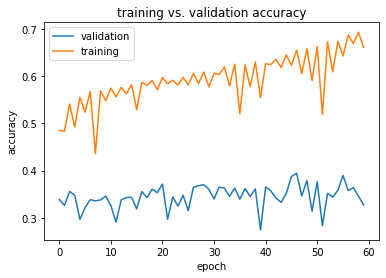

In [ ]:
#plotting validation vs. testing accuracy to assess overfitting
#only use block after training a model, not loading since train and validation accuracy over each epoch not saved in .pth.

plt.plot(test_accuracy,label = "validation")
plt.plot(train_accuracy, label = "training")
plt.title("training vs. validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

In [ ]:
#creating a test dataset to evaluate different models on

train_len = int(len(ds10)*(4/5))
test_len = len(ds10) - train_len
test_ds = []
for i in range(train_len,len(ds10)):
  image,target = ds10[i]
  image = image.numpy()
  image = np.stack([image[:,:,7],image[:,:,6],image[:,:,5],image[:,:,4],image[:,:,3],image[:,:,2],image[:,:,1],image[:,:,0]], axis=-1)
  image_tensor = torch.transpose(torch.from_numpy(image),0,2)
    
  test_ds.append(tuple((image_tensor,target)))

  if(i%50==0):
    print(f'progress: {np.round_((i-train_len)/test_len,decimals = 2)*100}%')

progress: 10.0%
progress: 28.999999999999996%
progress: 48.0%
progress: 66.0%
progress: 85.0%


In [ ]:
import glob as glob

In [ ]:
#loading models using model I created from scratch
#model checkpoints and images can be found in the following bucket: https://s3.console.aws.amazon.com/s3/buckets/remote-sensing-landcover?region=us-east-2&tab=objects
#the best model checkpoint specfifically used can be downloaded by the following link : https://remote-sensing-landcover.s3.us-east-2.amazonaws.com/model_scratch_success/my_checkpoint_no_augmentations.pth.tar
accuracies = []

for name in glob.glob('/content/gdrive/MyDrive/model_scratch_success'+'/*.tar'): 
  accuracy = 0
  PATH = name
  print(name)
  checkpoint = torch.load(PATH)
  model = UNET(in_channels = 8, out_channels = 10,dropout = True, dropout_rate = 0).to(device)
  model.load_state_dict(checkpoint['state_dict'])
  model.to(device)
  
  with torch.no_grad():
    test_load_all = DataLoader(test_ds, batch_size = 10, shuffle=True)
    accuracy = check_accuracy(test_load_all, model, device="cuda",mode="val")
  accuracies.append([name, accuracy])


/content/gdrive/MyDrive/model_scratch_success/my_checkpoint_model_scratch_success_grid_distrotion_hflip_vflip_validation_test_accuracy_60epochs.pth.tar
Got 10017609/17563648 with acc 57.04 for validation
/content/gdrive/MyDrive/model_scratch_success/my_checkpoint_weighted_ce.pth.tar
Got 10171483/17563648 with acc 57.91 for validation
/content/gdrive/MyDrive/model_scratch_success/my_checkpoint_lr_00001.pth.tar
Got 9907092/17563648 with acc 56.41 for validation
/content/gdrive/MyDrive/model_scratch_success/my_checkpoint_no_augmentations.pth.tar
Got 10556637/17563648 with acc 60.11 for validation


In [ ]:
#loading models using smp model

for name in glob.glob('/content/gdrive/MyDrive/smp'+'/*.tar'): 
  accuracy = 0
  print(name)
  PATH = name
  checkpoint = torch.load(PATH)
  model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None, in_channels = 8, classes = 10).to(device) #for dropout add aux_params

  model.load_state_dict(checkpoint['state_dict'])
  model.to(device)
  
  with torch.no_grad():
    test_load_all = DataLoader(test_ds, batch_size = 10, shuffle=True)
    accuracy = check_accuracy(test_load_all, model, device="cuda",mode="val")
  accuracies.append([name,accuracy])

/content/gdrive/MyDrive/smp/my_checkpoint_smp.pth.tar
Got 9804506/17563648 with acc 55.82 for validation


In [ ]:
from PIL import Image

**Cross Entropy vs. Weighted Cross Entropy**

Text(0.5, 1.0, 'grid distortion, hflip, vflip,and weighted cross entropy')

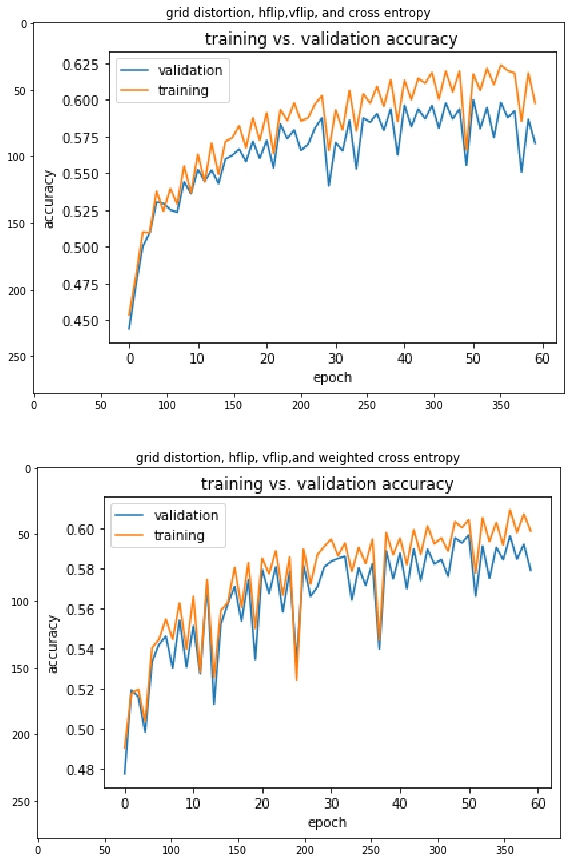

In [ ]:
fig, axs = plt.subplots(2,1)
im1 = Image.open("/content/gdrive/MyDrive/model_scratch_success/model_scratch_grid_distortion_hflip_vflip_weighted_ce_60epochs.png") 
im2 = Image.open("/content/gdrive/MyDrive/model_scratch_success/model_scratch_success_grid_distrotion_hflip_vflip_validation_test_accuracy_60epochs.png")
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0].imshow(im2)
axs[0].set_title("grid distortion, hflip,vflip, and cross entropy")
axs[1].imshow(im1)
axs[1].set_title("grid distortion, hflip, vflip,and weighted cross entropy")

In [ ]:
cross_entropy_accuracies = [accuracies[0][1], accuracies[1][1]]
names = ["cross_entropy","weighted_cross_entropy"]
cross_entropy_df = pd.DataFrame({'loss':names, 'accuracy':cross_entropy_accuracies})
print(cross_entropy_df)

                     loss                         accuracy
0           cross_entropy  tensor(0.5704, device='cuda:0')
1  weighted_cross_entropy  tensor(0.5791, device='cuda:0')


*Conclusion*

Although my final model did not include augmentations the two diagrams and accuracies above show the differences between cross entropy and weighted cross entropy on the dataset. The reasoning to use weighted cross entropy was because the dataset was found to be highly imbalanced (as shown in the 9 class histogram in visualizations). Based on what is shown there is not much of a difference in accuracy (weighted cross entropy is only .87%) and there are not many differences in the plots except that weighted cross entropy's plot might be a little more erratic. Overall, at least on this dataset, the results for each accuracy are so similar that it doesn't matter which is chosen.

**lr = 0.0001 vs. 0.00001**

Text(0.5, 1.0, 'lr = 0.00001 (grid distortion, hflip, and vflip applied)')

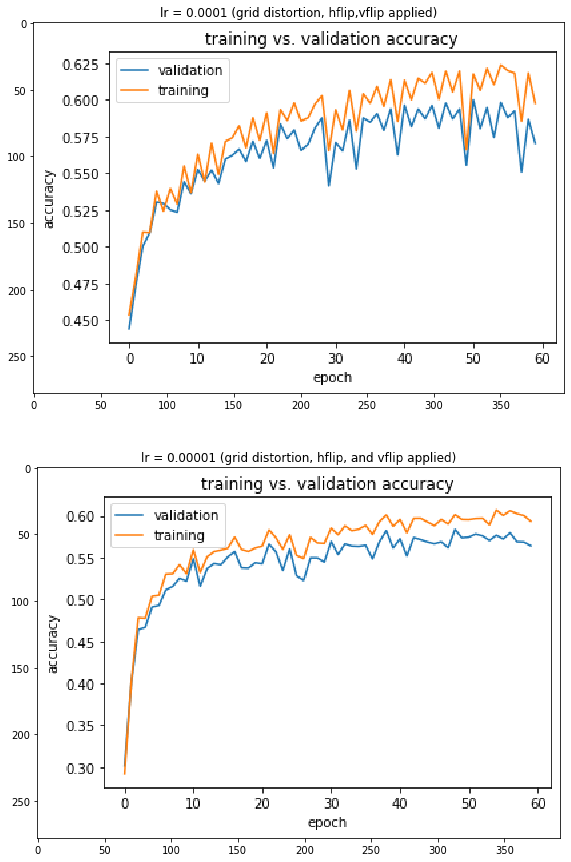

In [ ]:
fig, axs = plt.subplots(2,1)
im1 = Image.open("/content/gdrive/MyDrive/model_scratch_success/model_scratch_success_lr_00001_hflip_vflip_grid_distortion_training_validation_accuracy_60epochs.png") 
im2 = Image.open("/content/gdrive/MyDrive/model_scratch_success/model_scratch_success_grid_distrotion_hflip_vflip_validation_test_accuracy_60epochs.png")
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0].imshow(im2)
axs[0].set_title("lr = 0.0001 (grid distortion, hflip,vflip applied)")
axs[1].imshow(im1)
axs[1].set_title("lr = 0.00001 (grid distortion, hflip, and vflip applied)")

In [ ]:
lr_accuracies = [accuracies[0][1], accuracies[2][1]]
names = ['0.0001','0.00001']
lr_df = pd.DataFrame({'learning rate':names, 'accuracy':lr_accuracies})
print(lr_df)

  learning rate                         accuracy
0        0.0001  tensor(0.5704, device='cuda:0')
1       0.00001  tensor(0.5641, device='cuda:0')


*Conclusion*

In my case I had used a scheduler for my model called CosineAnnealingLR so the only issue was to find the initial learning rate. Learning rate is important because if the learning rate is too large the model might not converge or find any minima and if the learning rate is too small the model may take a long time to converge and it may not even be a global minimum. In this case I compared lr = 0.0001 and 0.00001. While both models had an upward curve and the validation accuracy grew with the training accuracy, lr =0.0001 was more accurate by .63% and the overall maximum accuracy that could be attained was also larger. For this reason I chose to use lr = 0.0001. It is likely that the accuracy for lr = 0.00001 may have increased over a larger number of epochs but for the sake of consistency I stuck with 60 epochs.

**Augmentations vs. No Augmentations**

Text(0.5, 1.0, 'no augmentations')

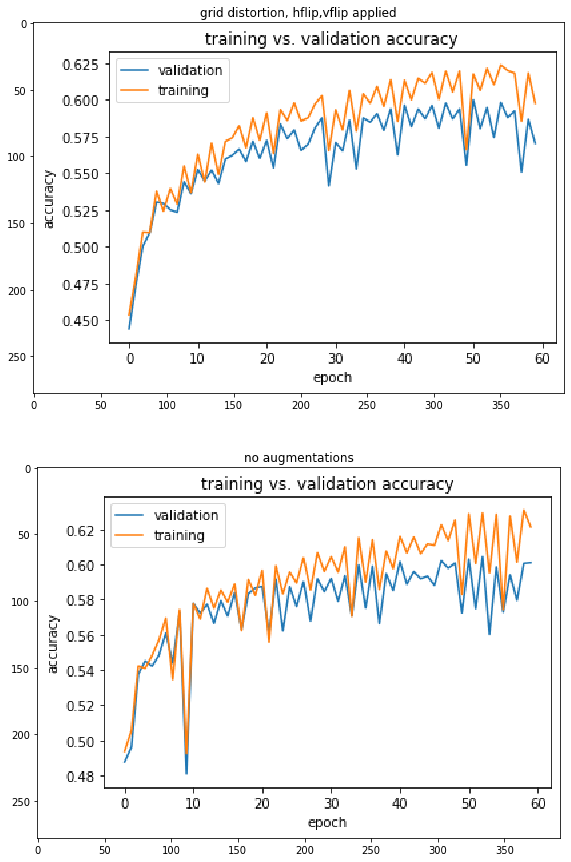

In [ ]:
fig, axs = plt.subplots(2,1)
im1 = Image.open("/content/gdrive/MyDrive/model_scratch_success/model_scratch_no_augmentation_60epochs.png") 
im2 = Image.open("/content/gdrive/MyDrive/model_scratch_success/model_scratch_success_grid_distrotion_hflip_vflip_validation_test_accuracy_60epochs.png")
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0].imshow(im2)
axs[0].set_title("grid distortion, hflip,vflip applied")
axs[1].imshow(im1)
axs[1].set_title("no augmentations")

In [ ]:
aug_accuracies = [accuracies[0][1], accuracies[3][1]]
names = ['yes','no']
aug_df = pd.DataFrame({'augmentation?':names, 'accuracy':aug_accuracies})
print(aug_df)

  augmentation?                         accuracy
0           yes  tensor(0.5704, device='cuda:0')
1            no  tensor(0.6011, device='cuda:0')


*Conclusion*

I decided to use random augmentations on my dataset since they have been shown to increase performance. I believe, however, that I may have used it incorrectly. Instead of augmenting the dataset, adding it the original dataset, and feeding it to the model I augmented the existing dataset. From that reasoning it makes sense that the augmentations did not work out and having no augmentations increased accuracy dramatically by 3.07%. Given the difference in accuracy from this point on I moved forward with no augmentations. A more skillful way to use augmentations here may have been to generate more images in the dataset to balance out the distribution or just to generate more images to improve generalization.  

Normalization vs. No Normalization

Text(0.5, 1.0, 'min max normalization')

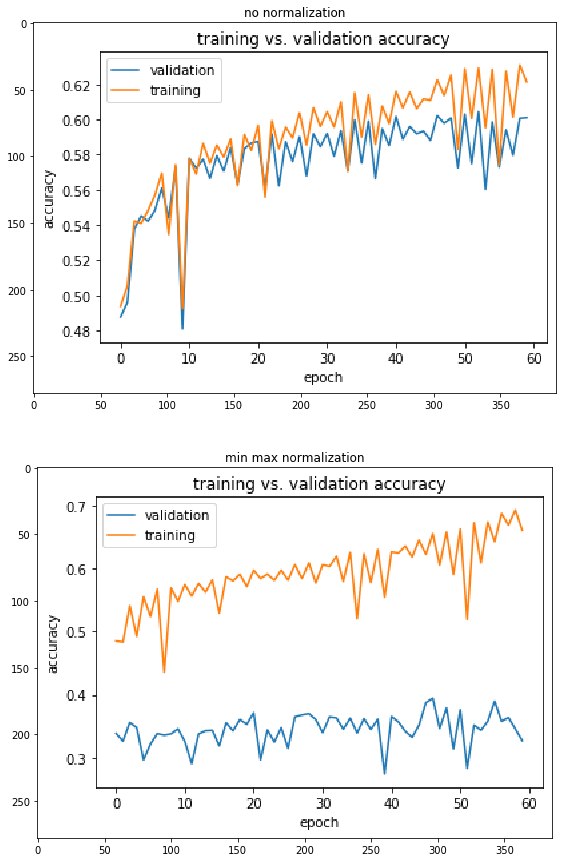

In [ ]:
fig, axs = plt.subplots(2,1)
im2 = Image.open("/content/gdrive/MyDrive/model_scratch_success/model_scratch_no_augmentation_60epochs.png") 
im1 = Image.open("/content/gdrive/MyDrive/model_scratch_success/min_max_normalization_test_and_train.png")
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0].imshow(im2)
axs[0].set_title("no normalization")
axs[1].imshow(im1)
axs[1].set_title("min max normalization")

In [ ]:
#for normalization I couldn't download the .tar for some reason but I have screenshot in my bucket
#if you want to verify the accuracy

norm_accuracies = [.3271, accuracies[3][1]]
names = ['yes','no']
norm_df = pd.DataFrame({'normalization?':names, 'accuracy':norm_accuracies})
print(norm_df)

  normalization?                         accuracy
0            yes                            32.71
1             no  tensor(0.6011, device='cuda:0')


*Conclusion*

Normalization has been shown to increase performance so I decided to try it on my dataset. Unfortunately, however, I either applied it incorrectly or it just did not work because the plot (shown above) for when normalization was used has training and validation accuracy very far apart for the whole training cycle and the overall accuracy was 27.4% worse than that with normalization. For this reason I decided not to use normalization

**Evaluation**

In [ ]:
#isolating best model

max_accuracy = 0
best_model_index= 0
for i in range(len(accuracies)):
  print(i)
  if(accuracies[i][1].detach().cpu().numpy() > max_accuracy):
    max_accuracy = accuracies[i][1].detach().cpu().numpy()
    best_model_index = i
    

0
1
2
3
4


In [ ]:

PATH = accuracies[best_model_index][0]

checkpoint = torch.load(PATH)
model = UNET(in_channels = 8, out_channels = 10,dropout = True, dropout_rate = 0).to(device)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)

def return_accuracy(test_ds, batch_size,model):
  '''
  returns test accuracy given batch size, a model and a given test set

  INPUTS:

  model : <model> saved model that can predict appropriately
  
  test_ds : test dataset, should be in format of (image,mask)

  batch_size : how many images wanted to predict at a time

  
  '''
  with torch.no_grad():
    test_load_all = DataLoader(test_ds, batch_size = batch_size, shuffle=True)
    accuracy = check_accuracy(test_load_all, model, device="cuda",mode="val")
  return accuracy

return_accuracy(test_ds,batch_size=10,model = model)

Got 10556637/17563648 with acc 60.11 for validation


tensor(0.6011, device='cuda:0')

'https://storage.googleapis.com/naip_public/images/landsat:LC08:PRE:TOAR_6:125:30.0:12:-1096:20341.tif'

In [ ]:
#function to read in input file and output raster

def model_evaluation(model,input, is_file,checkpoint = checkpoint):
  '''
  outputs single band classification raster based on model/checkpoint

  INPUTS:

  model : <model> saved model that can predict appropriately
  
  checkpoint : a previously saved version of the model

  is_file : if the input is a file ( as a filename ) or an image ( as a pytorch tensor )

  OUTPUTS:

  single band classification raster
  '''
  image = []
  if(checkpoint):
    model = UNET(in_channels = 8, out_channels = 10,dropout = True, dropout_rate = 0).to(device)
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
  if(is_file):
    with rasterio.open(input) as src:
      img = np.transpose(src.read(), axes=(1, 2, 0)).astype(np.int16)
    image = torch.from_numpy(img)
  image = image.view(256, 256, 10).type(torch.float32)
  image = image.numpy()
  image = np.stack([image[:,:,7],image[:,:,6],image[:,:,5],image[:,:,4],image[:,:,3],image[:,:,2],image[:,:,1],image[:,:,0]], axis=-1)
  image = torch.transpose(torch.from_numpy(image),0,2)
  image = image.view(-1,8,256,256).type(torch.float32).to(device)
  preds = torch.nn.LogSoftmax(dim=1)(model(image))        
  preds = torch.argmax(preds,dim=1).type(torch.uint8).view(-1,256,256)
  target = preds
  print(image.detach().cpu().size())
  display_image_target([torch.transpose(image.view(8,256,256),0,2).detach().cpu(),target.detach().cpu()])
  return target

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 8, 256, 256])


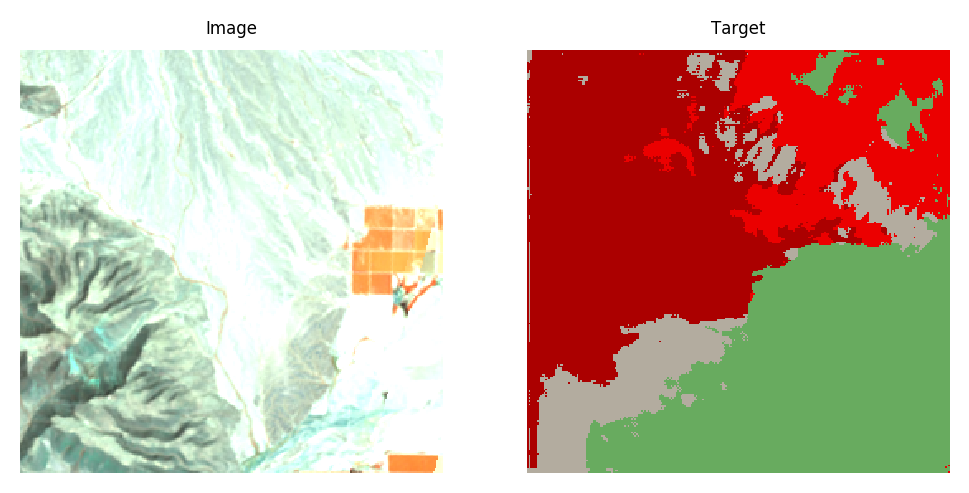

In [ ]:
tgt = model_evaluation(model,samples[0][0],is_file = True,checkpoint = None)

In [ ]:
#attempt at creating confusion matrix
#large part of code taken from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
'''from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for batch, (image, target) in enumerate(test_load_all):
        image = image.type(torch.float32).to(device)
        target =target.type(torch.long).view(-1,256,256).to(device)

        preds = torch.nn.LogSoftmax(dim=1)(model(image))
        preds = torch.argmax(preds,dim=1).type(torch.uint8).view(-1,256,256)
        preds = preds.detach().cpu().numpy().flatten()
        y_pred.extend(preds) # Save Prediction
        
        target = target.detach().cpu().numpy().flatten()
        y_true.extend(target) # Save Truth

# constant for classes
classes = ('water', 'snow/ice', 'built area', 'bare', 'forest', 'shrub/scrub', 'grass', 'crops', 'wetlands')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/len(y_true), index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')'''